# Analisis Clustering untuk Dataset Campaign

Notebook ini mengimplementasikan dua model clustering (K-Means dan Hierarchical Clustering) dan evaluasi dengan berbagai metrik.

## Bagian 1: Persiapan Data dan EDA

Pada bagian ini, kita akan melakukan persiapan library, memuat dataset, dan melakukan eksplorasi data awal. Eksplorasi data awal sangat penting untuk memahami karakteristik dataset sebelum melakukan analisis clustering.

In [114]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import warnings
warnings.filterwarnings("ignore")

# Set style untuk plot
plt.style.use('fivethirtyeight')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)

### Memuat dan Memeriksa Dataset

Dataset `clusteringcampaign.csv` menggunakan separator tab (`\t`) bukan koma. Mari kita muat dan periksa strukturnya.

In [115]:
# Memuat dataset dengan separator tab (\t)
df = pd.read_csv('clusteringcampaign.csv', sep='\t')

# Melihat informasi dasar dataset
print("Informasi Dataset:")
print(f"Jumlah baris: {df.shape[0]}")
print(f"Jumlah kolom: {df.shape[1]}")
print("\nLima baris pertama:")
display(df.head())

# Memeriksa informasi data
print("\nInformasi Data:")
df.info()

# Statistik deskriptif
print("\nStatistik Deskriptif:")
display(df.describe())

# Memeriksa missing values
print("\nJumlah missing values per kolom:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "Tidak ada missing values")

Informasi Dataset:
Jumlah baris: 2240
Jumlah kolom: 29

Lima baris pertama:


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0



Informasi Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000



Jumlah missing values per kolom:
Income    24
dtype: int64


### Visualisasi Distribusi Fitur

Visualisasi distribusi membantu kita memahami karakteristik dari setiap fitur. Kita dapat melihat apakah data terdistribusi normal, miring, atau memiliki outlier yang dapat mempengaruhi hasil clustering.

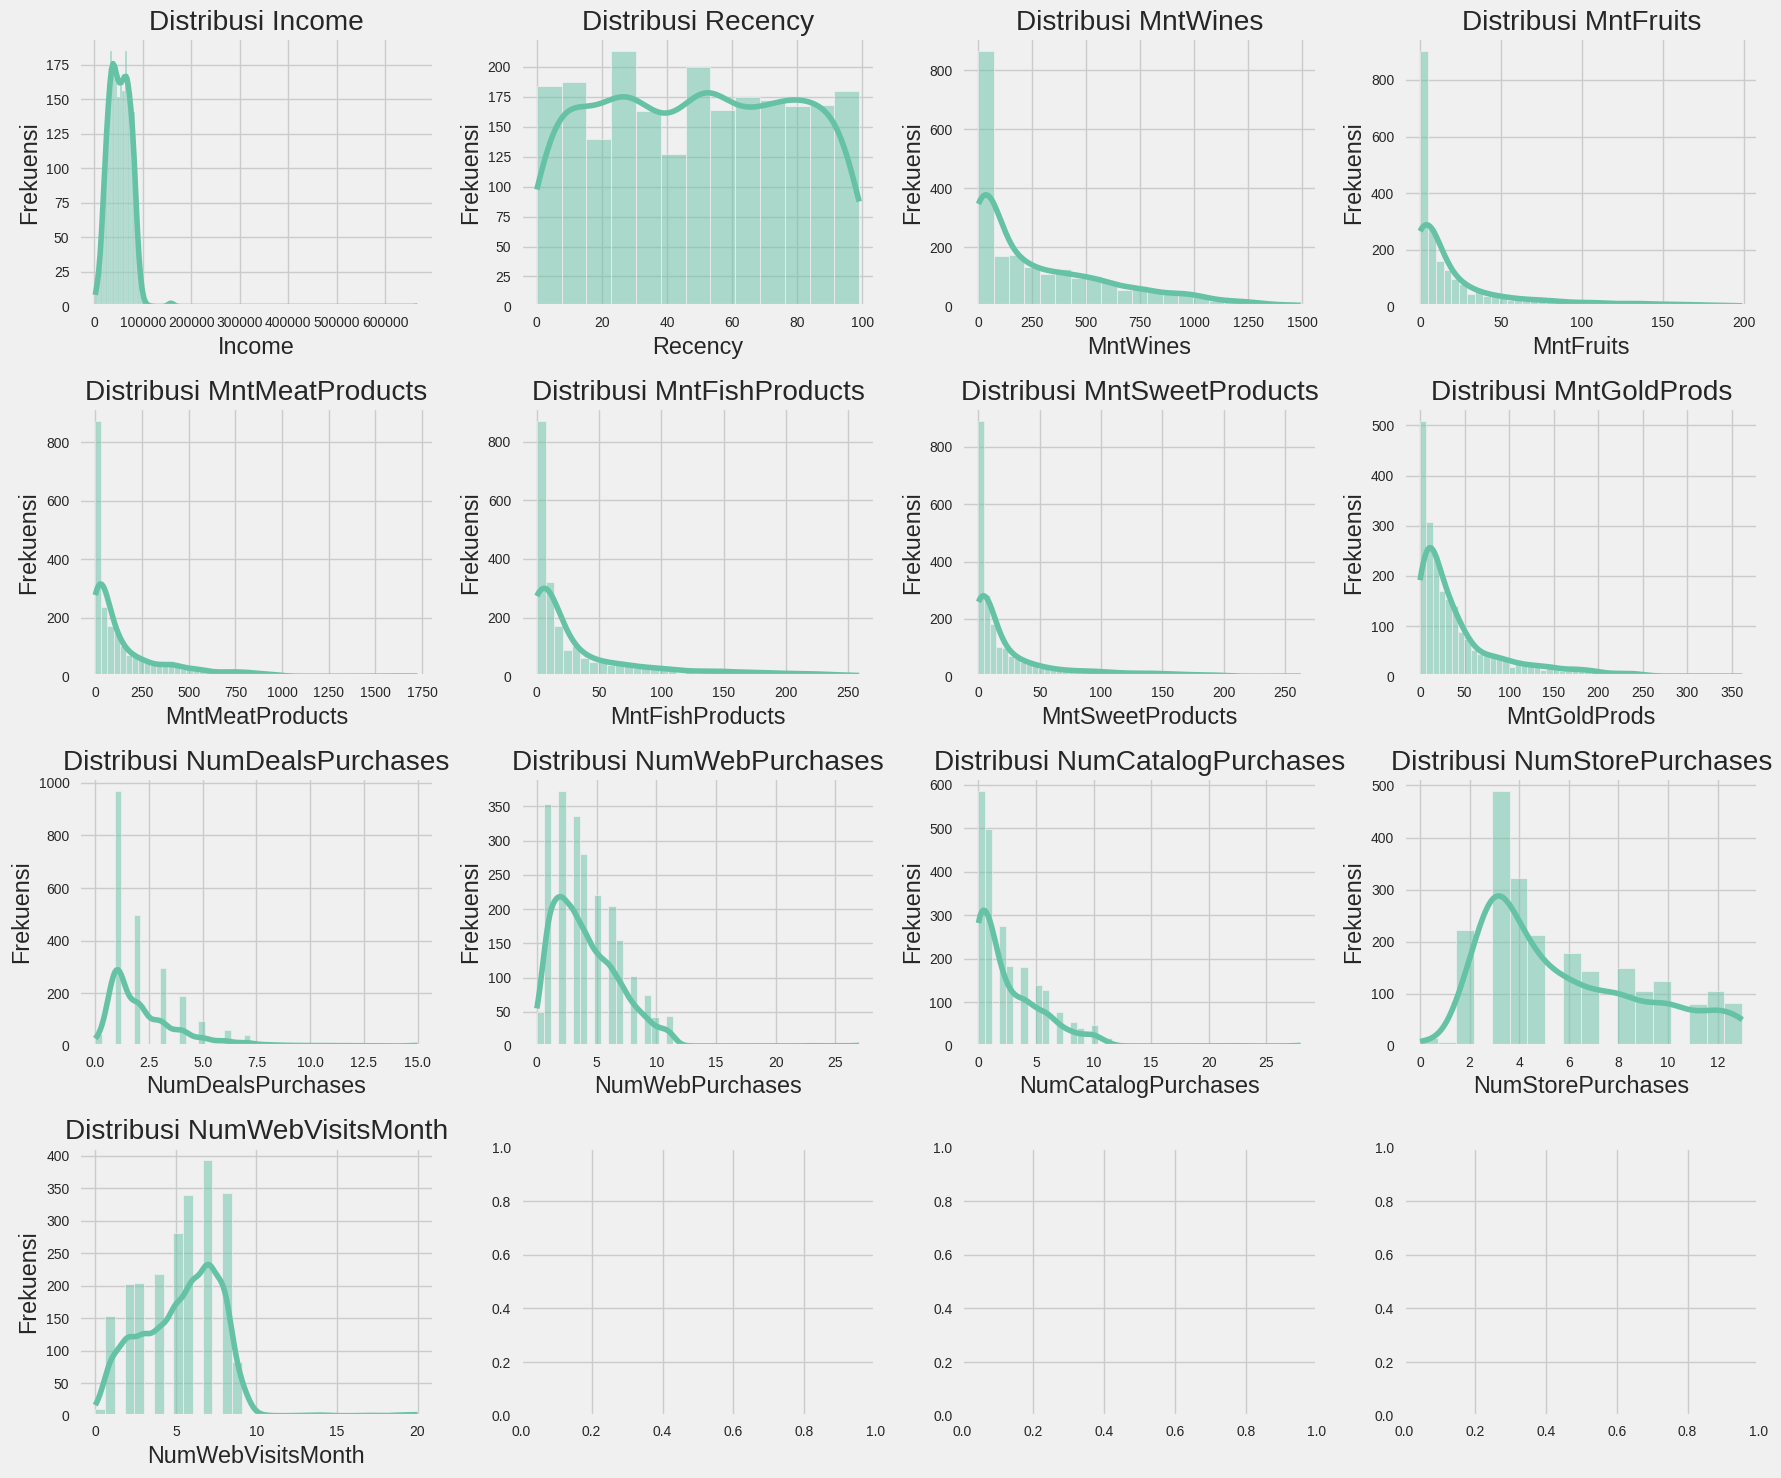

In [116]:
# Plot distribusi untuk beberapa fitur numerik penting
def plot_distributions(df, columns, nrows, ncols):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 15))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.histplot(df[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribusi {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frekuensi')

    plt.tight_layout()
    plt.show()

# Pilih beberapa kolom numerik untuk visualisasi
numerical_cols = ['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
                 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
                 'NumStorePurchases', 'NumWebVisitsMonth']

plot_distributions(df, numerical_cols, 4, 4)

### Analisis Korelasi

Matriks korelasi membantu kita memahami hubungan antar variabel. Korelasi tinggi antara variabel dapat mempengaruhi hasil clustering, karena variabel yang berkorelasi tinggi akan memiliki bobot lebih dalam algoritma.

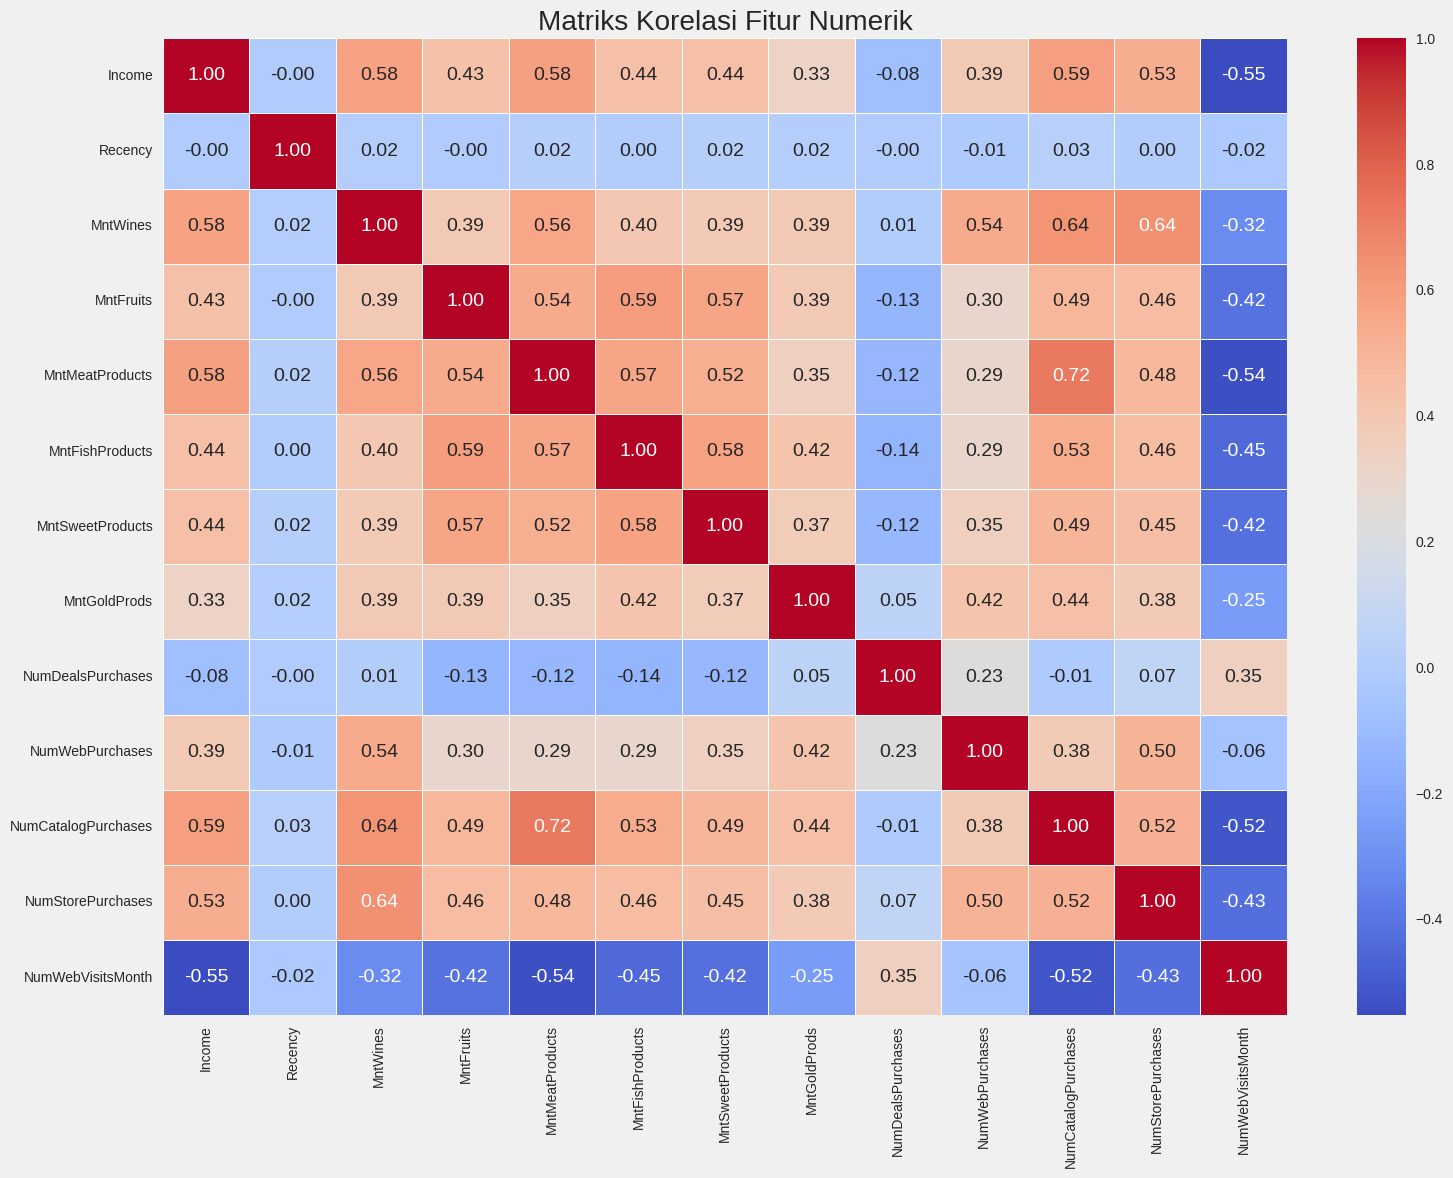

In [117]:
# Visualisasi korelasi antar fitur
plt.figure(figsize=(16, 12))
correlation = df[numerical_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriks Korelasi Fitur Numerik')
plt.tight_layout()
plt.show()

### Persiapan Data untuk Clustering

Sebelum menerapkan algoritma clustering, kita perlu mempersiapkan data dengan langkah-langkah berikut:
1. Memilih fitur yang relevan untuk clustering
2. Menangani fitur kategoris dengan one-hot encoding
3. Standardisasi fitur numerik agar algoritma tidak bias terhadap fitur dengan skala besar

In [118]:
# Persiapan data untuk clustering

# 1. Seleksi fitur yang akan digunakan
features = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
           'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
           'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
           'NumStorePurchases', 'NumWebVisitsMonth']

# Fitur kategorikal
categorical_features = ['Education', 'Marital_Status']

# 2. Memeriksa nilai yang hilang (missing values)
missing_values = df.isnull().sum()
print("\nJumlah nilai yang hilang per kolom:")
print(missing_values[missing_values > 0])

# Persentase nilai yang hilang
missing_percentage = (df.isnull().sum() / len(df)) * 100
print("\nPersentase nilai yang hilang per kolom:")
print(missing_percentage[missing_percentage > 0])

# 3. Menangani nilai yang hilang (NaN)
# Untuk kolom numerik, gunakan median
for col in features:
    if df[col].isnull().sum() > 0:
        median_value = df[col].median()
        print(f"Mengisi nilai NaN pada kolom {col} dengan median: {median_value}")
        df[col] = df[col].fillna(median_value)

# Untuk kolom kategorikal, gunakan modus
for col in categorical_features:
    if df[col].isnull().sum() > 0:
        mode_value = df[col].mode()[0]
        print(f"Mengisi nilai NaN pada kolom {col} dengan modus: {mode_value}")
        df[col] = df[col].fillna(mode_value)

# Memastikan tidak ada nilai NaN yang tersisa
print("\nJumlah nilai NaN yang tersisa setelah imputasi:", df.isnull().sum().sum())

# 4. Pisahkan fitur numerik dan kategorikal
X_numerical = df[features].copy()
X_categorical = df[categorical_features].copy()

# 5. Preprocessing data
# Melakukan one-hot encoding pada fitur kategorikal
print("\nDistribusi fitur kategorikal:")
for col in categorical_features:
    print(f"\nDistribusi {col}:")
    print(df[col].value_counts())

# Membuat pipeline untuk preprocessing
# - Fitur numerik akan di-standardisasi
# - Fitur kategorikal akan di-one-hot encoding
numerical_transformer = StandardScaler()

# Kompatibel dengan berbagai versi scikit-learn
try:
    # Untuk scikit-learn versi 0.24+
    categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)
except TypeError:
    # Untuk scikit-learn versi lama
    categorical_transformer = OneHotEncoder(drop='first', sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Implemen pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Lakukan preprocessing
X_processed = pipeline.fit_transform(df[features + categorical_features])

print("\nBentuk data setelah preprocessing:", X_processed.shape)
print("Data preprocessed siap untuk clustering")


Jumlah nilai yang hilang per kolom:
Income    24
dtype: int64

Persentase nilai yang hilang per kolom:
Income    1.071429
dtype: float64
Mengisi nilai NaN pada kolom Income dengan median: 51381.5

Jumlah nilai NaN yang tersisa setelah imputasi: 0

Distribusi fitur kategorikal:

Distribusi Education:
Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64

Distribusi Marital_Status:
Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

Bentuk data setelah preprocessing: (2240, 26)
Data preprocessed siap untuk clustering


In [119]:
# Membuat pipeline untuk preprocessing
# - Fitur numerik akan di-standardisasi
# - Fitur kategorikal akan di-one-hot encoding
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Implemen pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Lakukan preprocessing
X_processed = pipeline.fit_transform(df[features + categorical_features])

print("\nBentuk data setelah preprocessing:", X_processed.shape)
print("Data preprocessed siap untuk clustering")


Bentuk data setelah preprocessing: (2240, 26)
Data preprocessed siap untuk clustering


## Bagian 2: K-Means Clustering dan Evaluasi

Pada bagian ini, kita akan mengimplementasikan algoritma K-Means Clustering dan mengevaluasi hasilnya dengan berbagai metrik.

### Penjelasan Matematis: Algoritma K-Means

K-Means adalah algoritma clustering partitional yang membagi dataset menjadi K cluster non-overlapping. Algoritma bekerja dengan prinsip-prinsip berikut:

1. **Inisialisasi**: Pilih K centroid secara acak atau dengan metode seperti K-Means++
2. **Penetapan Cluster**: Tetapkan setiap data point ke cluster terdekat, berdasarkan jarak Euclidean:
   $d(x_i, c_j) = \sqrt{\sum_{k=1}^{n} (x_{ik} - c_{jk})^2}$
   
   Dimana:
   - $x_i$ adalah data point i
   - $c_j$ adalah centroid cluster j
   - $n$ adalah jumlah dimensi
   
3. **Update Centroid**: Hitung ulang centroid sebagai rata-rata dari semua data point dalam cluster:
   $c_j = \frac{1}{|C_j|} \sum_{x_i \in C_j} x_i$
   
   Dimana $|C_j|$ adalah jumlah data point dalam cluster j
   
4. **Iterasi**: Ulangi langkah 2 dan 3 hingga centroid tidak berubah signifikan atau mencapai jumlah iterasi maksimum

Tujuan K-Means adalah untuk meminimalkan Within-Cluster Sum of Squares (WCSS):
$WCSS = \sum_{j=1}^{K} \sum_{x_i \in C_j} ||x_i - c_j||^2$

### Penjelasan Matematis: Elbow Method

Elbow Method digunakan untuk menentukan jumlah optimal cluster (k) dengan menghitung Within-Cluster Sum of Squares (WCSS) untuk setiap nilai k dan memplot grafiknya.

WCSS dihitung dengan rumus:
$WCSS = \sum_{i=1}^{K} \sum_{x \in C_i} ||x - c_i||^2$
    Dimana:
    - $x$ adalah data point
    - $c_i$ adalah centroid dari cluster i
    - $||x - c_i||$ adalah jarak Euclidean antara x dan $c_i$

Saat menambahkan jumlah cluster, WCSS akan selalu berkurang, karena:
- Titik data akan lebih dekat ke centroid mereka
- Pada ekstremnya, jika k = n (jumlah data), maka WCSS = 0

Metode elbow mencari "siku" (elbow) dalam grafik, yaitu titik di mana penambahan cluster tidak lagi memberikan penurunan WCSS yang signifikan.

Implementasi Elbow Method untuk K-Means


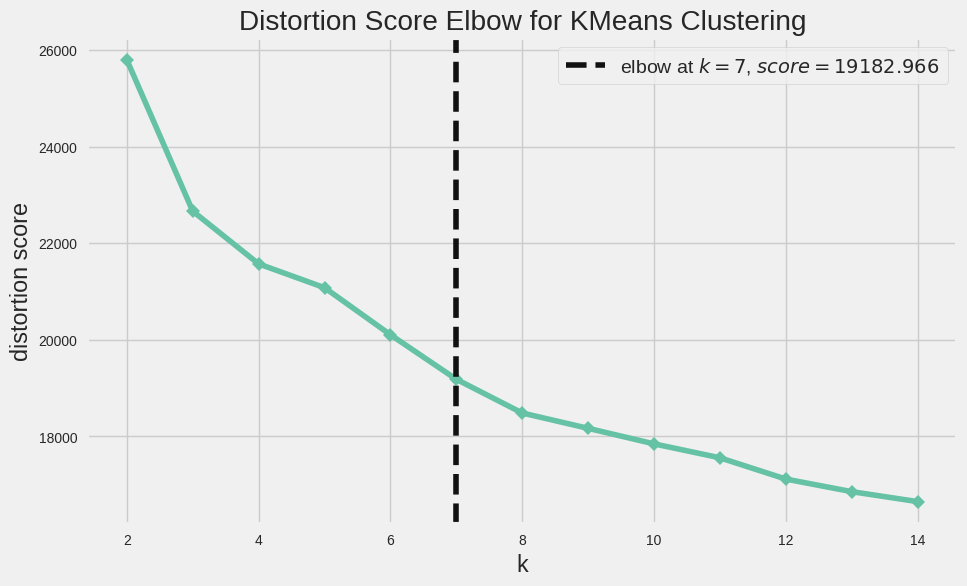

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [120]:
# Implementasi Elbow Method untuk K-Means
print("Implementasi Elbow Method untuk K-Means")
print("="*50)

# Visualisasi Elbow Method dengan yellowbrick
plt.figure(figsize=(10, 6))
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(2, 15), metric='distortion', timings=False)
visualizer.fit(X_processed)
visualizer.show()

### Evaluasi dengan Multiple Metrics

Kita akan menggunakan beberapa metrik evaluasi untuk menilai kualitas clustering dengan berbagai jumlah cluster. Ini membantu kita menentukan jumlah cluster optimal secara lebih objektif.

In [121]:
# Hitung dan plot metrik evaluasi lain untuk berbagai jumlah cluster
n_clusters_range = range(2, 16)
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

print("\nEvaluasi metrik untuk berbagai jumlah cluster:")
print("{:<10} {:<20} {:<25} {:<20}".format('Clusters', 'Silhouette Score', 'Calinski-Harabasz Index', 'Davies-Bouldin Index'))
print("-" * 80)

for n_clusters in n_clusters_range:
    # Fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_processed)

    # Hitung metrik
    silhouette = silhouette_score(X_processed, cluster_labels)
    calinski = calinski_harabasz_score(X_processed, cluster_labels)
    davies_bouldin = davies_bouldin_score(X_processed, cluster_labels)

    # Simpan skor
    silhouette_scores.append(silhouette)
    calinski_scores.append(calinski)
    davies_bouldin_scores.append(davies_bouldin)

    print("{:<10d} {:<20.4f} {:<25.4f} {:<20.4f}".format(
        n_clusters, silhouette, calinski, davies_bouldin))


Evaluasi metrik untuk berbagai jumlah cluster:
Clusters   Silhouette Score     Calinski-Harabasz Index   Davies-Bouldin Index
--------------------------------------------------------------------------------
2          0.2922               930.2564                  1.4793              
3          0.2236               683.9783                  1.8011              
4          0.1324               516.5833                  2.0595              
5          0.1237               433.3936                  2.3370              
6          0.1269               383.6494                  2.2598              
7          0.1268               340.7376                  2.2415              
8          0.1182               311.2372                  2.1535              
9          0.1093               284.8463                  2.1543              
10         0.1060               262.6902                  2.2619              
11         0.1136               250.3865                  2.0732              
12

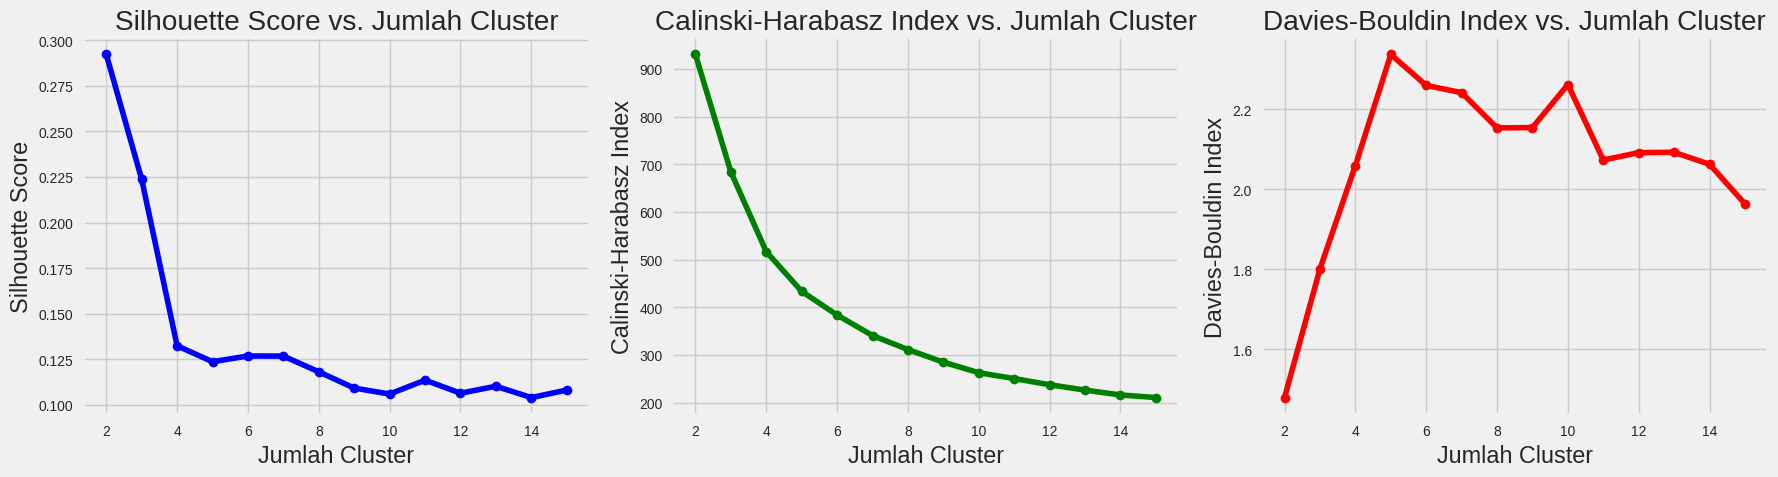

In [122]:
# Plot skor metrik evaluasi
plt.figure(figsize=(18, 5))

# Plot Silhouette Score
plt.subplot(1, 3, 1)
plt.plot(n_clusters_range, silhouette_scores, 'o-', color='blue')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Jumlah Cluster')
plt.grid(True)

# Plot Calinski-Harabasz Index
plt.subplot(1, 3, 2)
plt.plot(n_clusters_range, calinski_scores, 'o-', color='green')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index vs. Jumlah Cluster')
plt.grid(True)

# Plot Davies-Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(n_clusters_range, davies_bouldin_scores, 'o-', color='red')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs. Jumlah Cluster')
plt.grid(True)

plt.tight_layout()
plt.show()

### Penjelasan Matematis: Metrik Evaluasi Clustering

1. **SILHOUETTE COEFFICIENT**:
   Silhouette Coefficient mengukur seberapa baik suatu objek cocok dengan clusternya
   dibandingkan dengan cluster lainnya, dengan rentang nilai dari -1 hingga 1.
   
   Untuk setiap data point i, Silhouette dihitung dengan:
   $s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$
   
   Dimana:
   - $a(i)$ = jarak rata-rata antara i dan semua point lain dalam cluster yang sama
   - $b(i)$ = jarak rata-rata minimum antara i dan semua point di cluster lain
   
   Interpretasi:
   - Mendekati 1: Objek berada jauh dari cluster tetangga (clustering baik)
   - Mendekati 0: Objek berada di perbatasan antar cluster
   - Mendekati -1: Objek mungkin ditempatkan di cluster yang salah
   
   Silhouette Score keseluruhan adalah rata-rata dari $s(i)$ untuk semua data points.

2. **CALINSKI-HARABASZ INDEX (CH INDEX)**:
   Juga dikenal sebagai Variance Ratio Criterion, mengukur rasio antara
   dispersi antar-cluster dan dispersi intra-cluster.
   
   $CH = \frac{\text{trace}(B_k) / (k-1)}{\text{trace}(W_k) / (n-k)}$
   
   Dimana:
   - $B_k$ = matriks dispersi antar-cluster
   - $W_k$ = matriks dispersi intra-cluster
   - $k$ = jumlah cluster
   - $n$ = jumlah data points
   
   Nilai CH yang lebih tinggi menunjukkan clustering yang lebih baik.

3. **DAVIES-BOULDIN INDEX (DB INDEX)**:
   Mengukur jarak rata-rata antara setiap cluster dengan cluster yang paling mirip.
   
   $DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left(\frac{\sigma_i + \sigma_j}{d(c_i, c_j)}\right)$
   
   Dimana:
   - $\sigma_i$ = jarak rata-rata antara setiap point dalam cluster i dan centroidnya
   - $d(c_i, c_j)$ = jarak antara centroid i dan j
   
   Nilai DB yang lebih rendah menunjukkan clustering yang lebih baik.


Jumlah cluster optimal berdasarkan Silhouette Score: 2


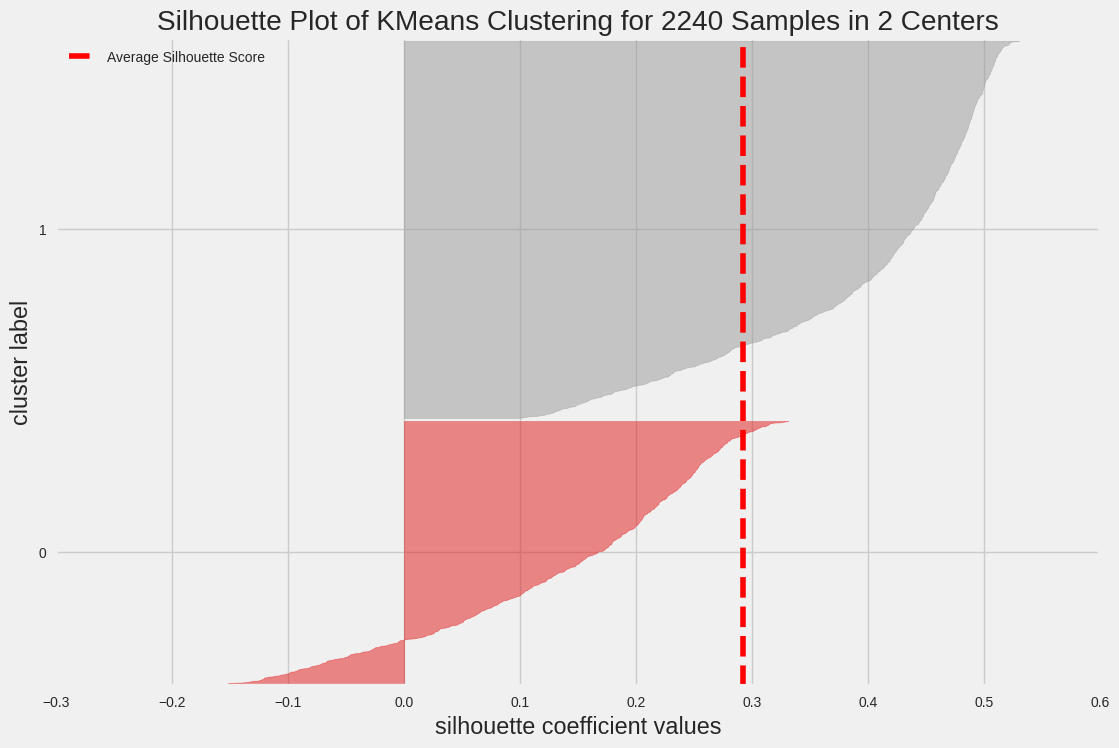

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 2240 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [123]:
# Berdasarkan evaluasi metrik, pilih jumlah cluster optimal
# Misalnya, kita pilih nilai optimal berdasarkan silhouette score
optimal_n_clusters = n_clusters_range[np.argmax(silhouette_scores)]
print(f"\nJumlah cluster optimal berdasarkan Silhouette Score: {optimal_n_clusters}")

# Visualisasi hasil Silhouette untuk jumlah cluster optimal
plt.figure(figsize=(12, 8))
visualizer = SilhouetteVisualizer(KMeans(n_clusters=optimal_n_clusters, random_state=42, n_init=10))
visualizer.fit(X_processed)
visualizer.show()

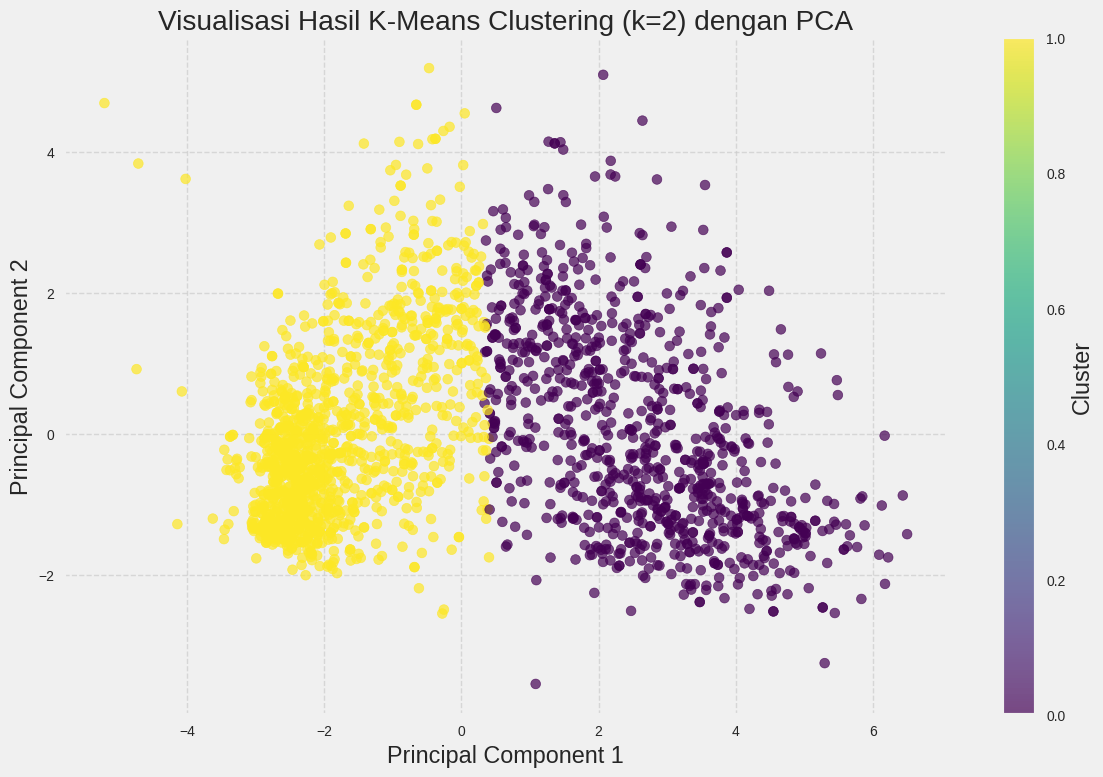

In [124]:
# Fit KMeans dengan jumlah cluster optimal
optimal_kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42, n_init=10)
df['Cluster_KMeans'] = optimal_kmeans.fit_predict(X_processed)

# Visualisasi hasil clustering dengan PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster_KMeans'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.title(f'Visualisasi Hasil K-Means Clustering (k={optimal_n_clusters}) dengan PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Analisis Profil Cluster K-Means

Setelah melakukan clustering, penting untuk menafsirkan hasil cluster dengan melihat karakteristik masing-masing cluster. Ini akan membantu kita memahami segmentasi pelanggan yang telah kita buat.


Profil Karakteristik Cluster K-Means:

Profil Karakteristik Cluster K-Means:
                         ID   Year_Birth        Income   Kidhome  Teenhome  \
Cluster_KMeans                                                               
0               5578.891068  1967.103486  71616.198802  0.067538  0.432462   
1               5601.373676  1969.987897  38781.690242  0.705749  0.557489   

                  Recency    MntWines  MntFruits  MntMeatProducts  \
Cluster_KMeans                                                      
0               49.626362  593.100218  55.288671       355.550109   
1               48.750378  103.139183   6.173979        35.985628   

                MntFishProducts  ...  NumWebVisitsMonth  AcceptedCmp3  \
Cluster_KMeans                   ...                                    
0                     78.550109  ...           3.676471      0.078431   
1                      9.037821  ...           6.455371      0.068835   

                AcceptedCmp4  AcceptedC

,Income,Kidhome,Teenhome,Recency,MntWines,MntMeatProducts,NumDealsPurchases,NumWebPurchases,NumStorePurchases
Cluster_KMeans,,,,,,,,,
0,71616.198802,0.067538,0.432462,49.626362,593.100218,355.550109,1.984749,5.772331,8.529412
1,38781.690242,0.705749,0.557489,48.750378,103.139183,35.985628,2.561271,2.913011,3.888048


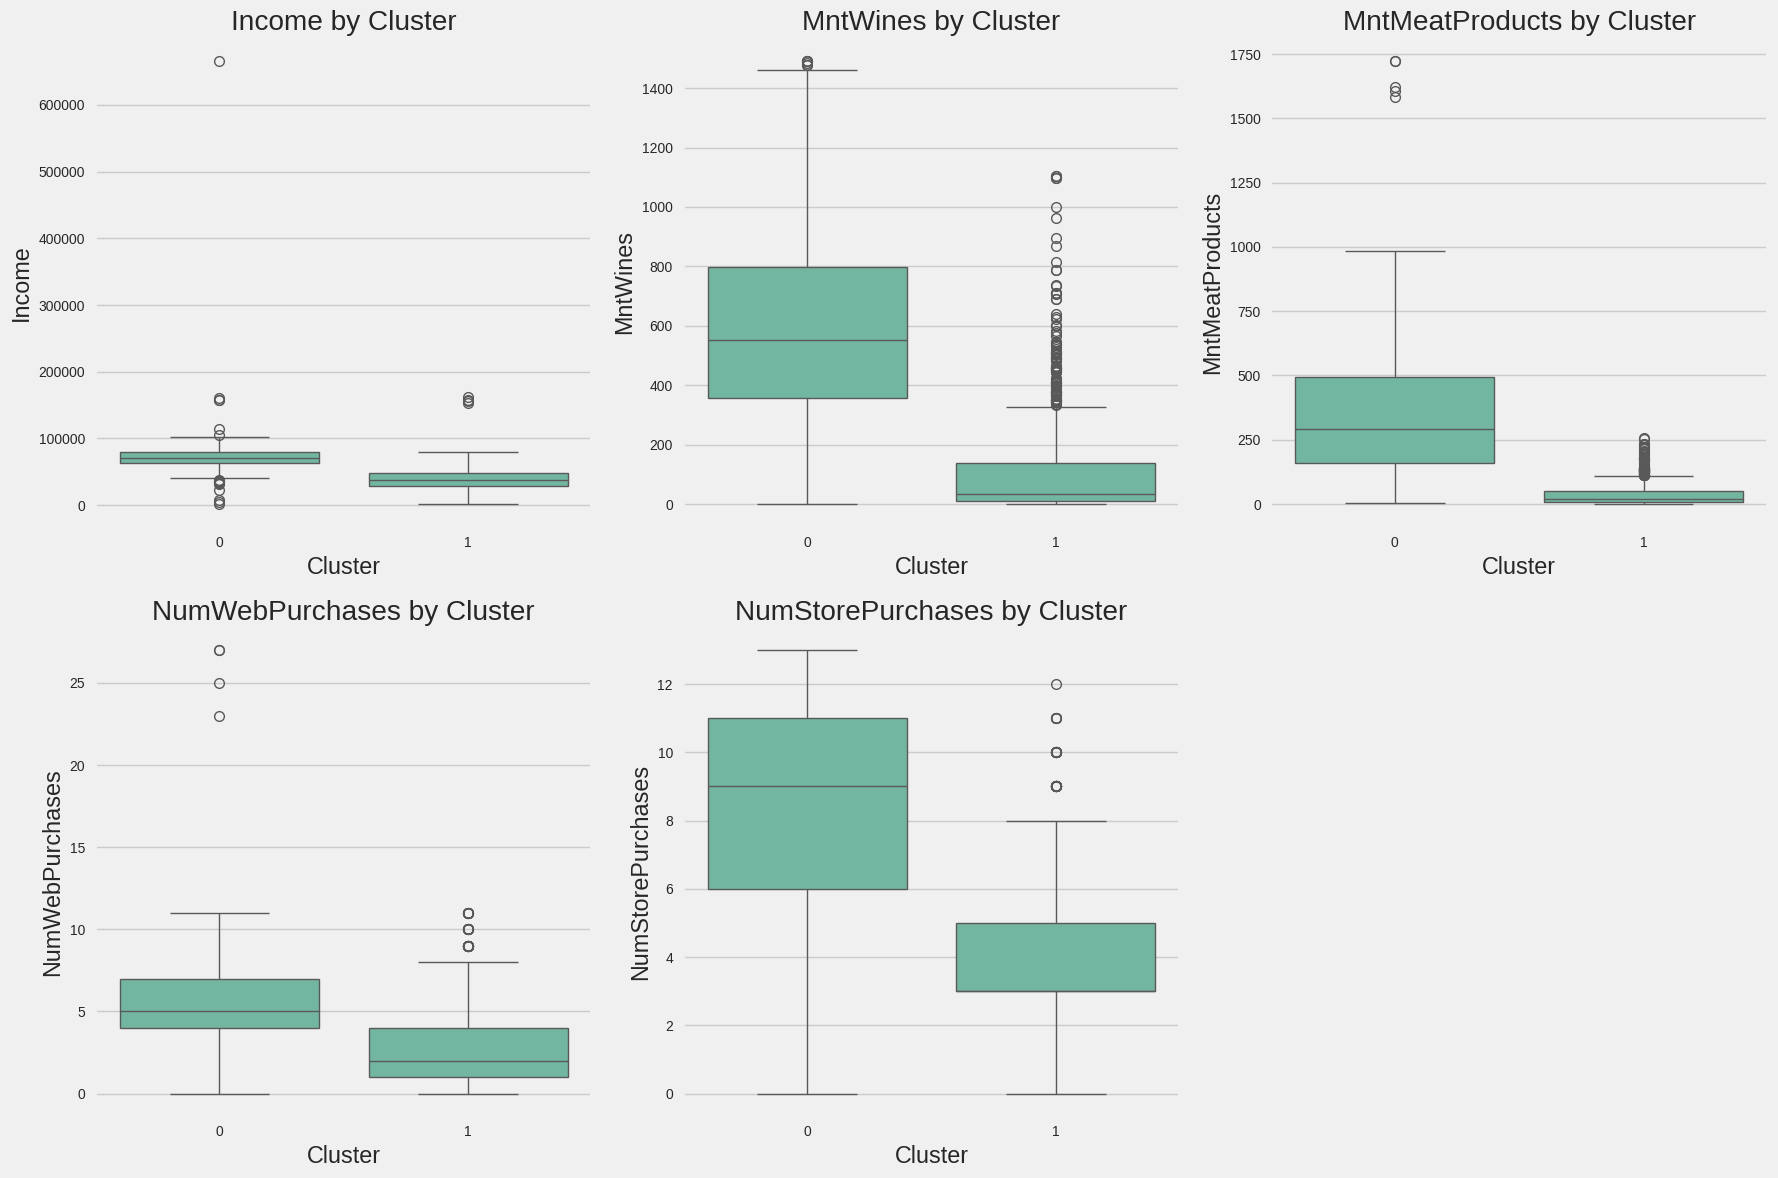

In [125]:
# Analisis cluster: profil karakteristik setiap cluster
print("\nProfil Karakteristik Cluster K-Means:")
numeric_columns = [col for col in df.columns if col not in categorical_features and col != 'Cluster_KMeans' and col != 'Cluster_HC']

# Gunakan hanya kolom numerik saat menghitung profil cluster
print("\nProfil Karakteristik Cluster K-Means:")
cluster_profile = df.groupby('Cluster_KMeans')[numeric_columns].mean(numeric_only=True)
print(cluster_profile)

# Untuk menganalisis kolom kategorikal, gunakan crosstab
print("\nDistribusi fitur kategorikal per cluster:")
for col in categorical_features:
    print(f"\nDistribusi {col} per Cluster:")
    # Gunakan crosstab untuk melihat distribusi kategori per cluster
    ct = pd.crosstab(df['Cluster_KMeans'], df[col])
    print(ct)
display(cluster_profile[['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntMeatProducts',
                        'NumDealsPurchases', 'NumWebPurchases', 'NumStorePurchases']])

# Visualisasi karakteristik cluster
plt.figure(figsize=(18, 12))
for i, feature in enumerate(['Income', 'MntWines', 'MntMeatProducts', 'NumWebPurchases', 'NumStorePurchases']):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='Cluster_KMeans', y=feature, data=df)
    plt.title(f'{feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

## Bagian 3: Hierarchical Clustering dan Evaluasi

Pada bagian ini, kita akan mengimplementasikan metode clustering kedua, yaitu Hierarchical Clustering (Agglomerative Clustering) dan membandingkannya dengan K-Means.

### Penjelasan Matematis: Hierarchical Clustering

Hierarchical Clustering adalah metode clustering yang membangun hirarki cluster dengan dua pendekatan:
1. **Agglomerative (bottom-up)**: Mulai dengan setiap titik data sebagai cluster sendiri, kemudian secara berulang menggabungkan cluster terdekat.
2. **Divisive (top-down)**: Mulai dengan satu cluster besar, kemudian secara berulang memisahkan cluster menjadi cluster yang lebih kecil.

Dalam implementasi ini, kita menggunakan pendekatan Agglomerative.

Jarak antar cluster diukur dengan berbagai metode linkage:

1. **Single linkage**: jarak terkecil antar elemen dari dua cluster
   $d(C_i, C_j) = \min\{d(x, y) : x \in C_i, y \in C_j\}$
   
2. **Complete linkage**: jarak terbesar antar elemen dari dua cluster
   $d(C_i, C_j) = \max\{d(x, y) : x \in C_i, y \in C_j\}$
   
3. **Average linkage**: jarak rata-rata antar elemen dari dua cluster
   $d(C_i, C_j) = \frac{1}{|C_i|\cdot|C_j|} \sum_{x \in C_i} \sum_{y \in C_j} d(x, y)$
   
4. **Ward's method**: meminimalkan peningkatan jumlah kuadrat kesalahan
   Jarak Ward menggunakan peningkatan jumlah kuadrat setelah menggabungkan dua cluster:
   $d(C_i, C_j) = \sqrt{\frac{|C_i|\cdot|C_j|}{|C_i|+|C_j|}} \cdot ||m_i - m_j||^2$
   
   Dimana $m_i$ dan $m_j$ adalah centroids dari $C_i$ dan $C_j$.

Algoritma Agglomerative Hierarchical Clustering secara detail:
1. Mulai dengan n cluster, di mana setiap cluster berisi tepat satu objek data
2. Hitung matriks jarak (atau kesamaan) antar semua pasangan cluster
3. Gabungkan dua cluster yang paling dekat (atau paling mirip)
4. Perbarui matriks jarak untuk mencerminkan jarak antara cluster baru dan cluster asli
5. Ulangi langkah 2-4 hingga semua objek berada dalam satu cluster atau sejumlah cluster yang diinginkan tercapai

Implementasi Hierarchical Clustering (Agglomerative)


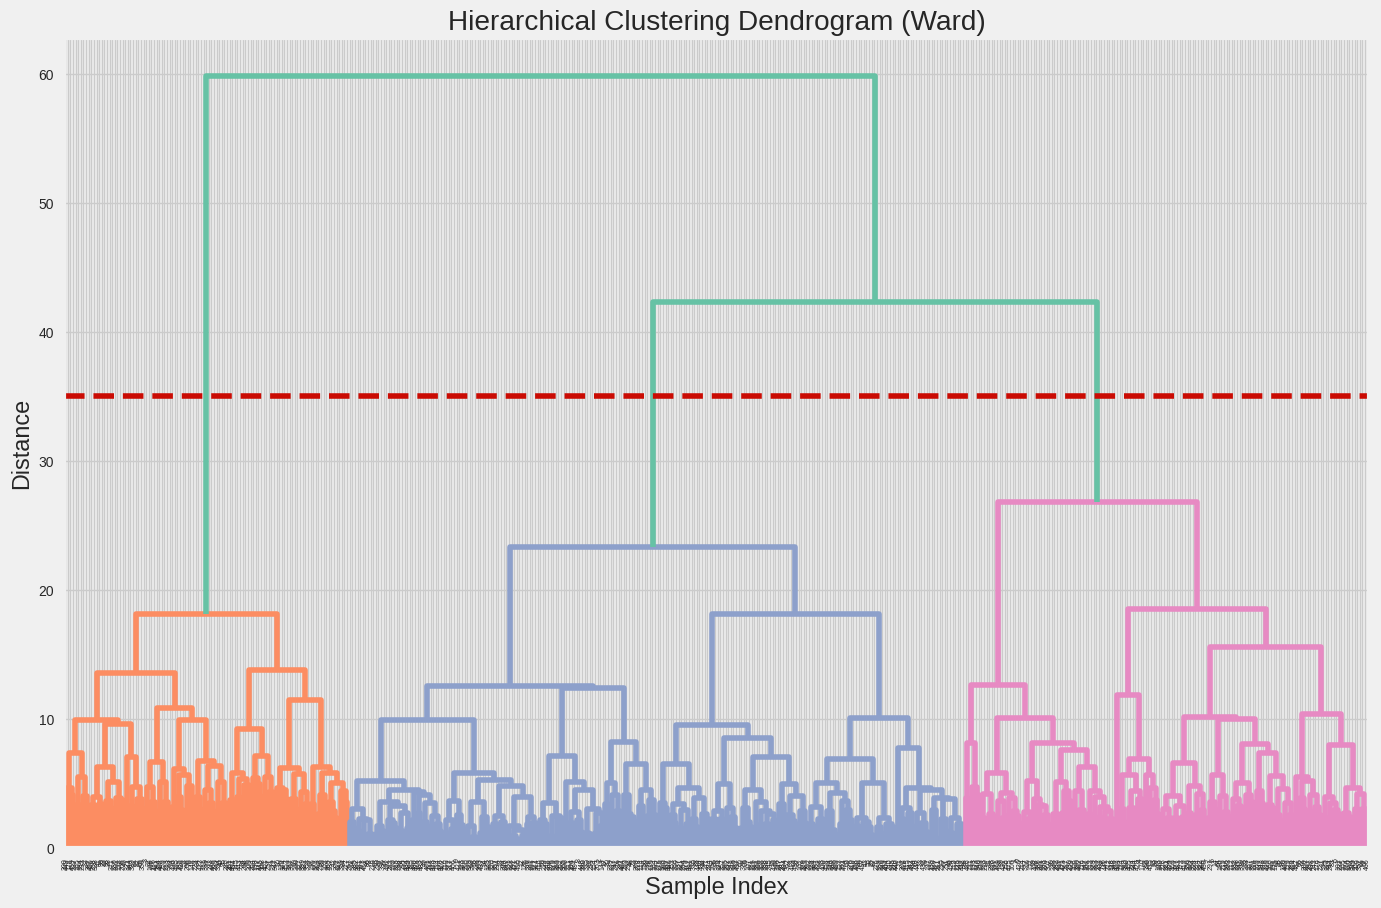

In [126]:
print("Implementasi Hierarchical Clustering (Agglomerative)")
print("="*50)

# Visualisasi dendrogram untuk memahami struktur hierarki dan menentukan jumlah cluster
plt.figure(figsize=(15, 10))
# Menggunakan sampel data karena dendrogram bisa sangat besar untuk dataset lengkap
# Kita ambil 500 sampel acak
np.random.seed(42)
sample_indices = np.random.choice(X_processed.shape[0], size=500, replace=False)
X_sample = X_processed[sample_indices]

# Compute linkage matrix
linkage_matrix = linkage(X_sample, method='ward')

# Plot dendrogram
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.axhline(y=35, color='r', linestyle='--')  # Garis horizontal untuk saran jumlah cluster
plt.show()

### Dendrogram dalam Hierarchical Clustering

Dendrogram adalah representasi visual struktur hierarki yang dihasilkan oleh hierarchical clustering. Sumbu x mewakili sampel data dan sumbu y mewakili jarak atau dissimilarity antar cluster yang digabungkan. Setiap garis vertikal mewakili penggabungan cluster, dan tinggi garis menunjukkan jarak/dissimilarity antara cluster yang digabungkan.

Dengan memotong dendrogram pada ketinggian tertentu (biasanya di mana 'lompatan' jarak terlihat besar), kita bisa menentukan jumlah cluster yang optimal. Pada visualisasi di atas, garis horizontal merah menunjukkan saran pemotongan untuk menentukan jumlah cluster.

In [127]:
# Evaluasi berbagai jumlah cluster seperti yang kita lakukan dengan K-Means
n_clusters_range = range(2, 16)
silhouette_scores_hc = []
calinski_scores_hc = []
davies_bouldin_scores_hc = []

print("\nEvaluasi metrik untuk Hierarchical Clustering:")
print("{:<10} {:<20} {:<25} {:<20}".format('Clusters', 'Silhouette Score', 'Calinski-Harabasz Index', 'Davies-Bouldin Index'))
print("-" * 80)

for n_clusters in n_clusters_range:
    # Fit Agglomerative Clustering
    hc = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = hc.fit_predict(X_processed)

    # Hitung metrik
    silhouette = silhouette_score(X_processed, cluster_labels)
    calinski = calinski_harabasz_score(X_processed, cluster_labels)
    davies_bouldin = davies_bouldin_score(X_processed, cluster_labels)

    # Simpan skor
    silhouette_scores_hc.append(silhouette)
    calinski_scores_hc.append(calinski)
    davies_bouldin_scores_hc.append(davies_bouldin)

    print("{:<10d} {:<20.4f} {:<25.4f} {:<20.4f}".format(
        n_clusters, silhouette, calinski, davies_bouldin))


Evaluasi metrik untuk Hierarchical Clustering:
Clusters   Silhouette Score     Calinski-Harabasz Index   Davies-Bouldin Index
--------------------------------------------------------------------------------
2          0.2820               763.9001                  1.5607              
3          0.1741               598.1009                  1.8764              
4          0.1670               452.7288                  1.9312              
5          0.1558               378.9548                  2.4030              
6          0.1177               334.2033                  2.4214              
7          0.0911               301.7651                  2.3724              
8          0.0909               276.5196                  2.3759              
9          0.0904               257.6600                  2.2185              
10         0.0910               241.9862                  1.9700              
11         0.0924               228.3428                  1.9258              
12

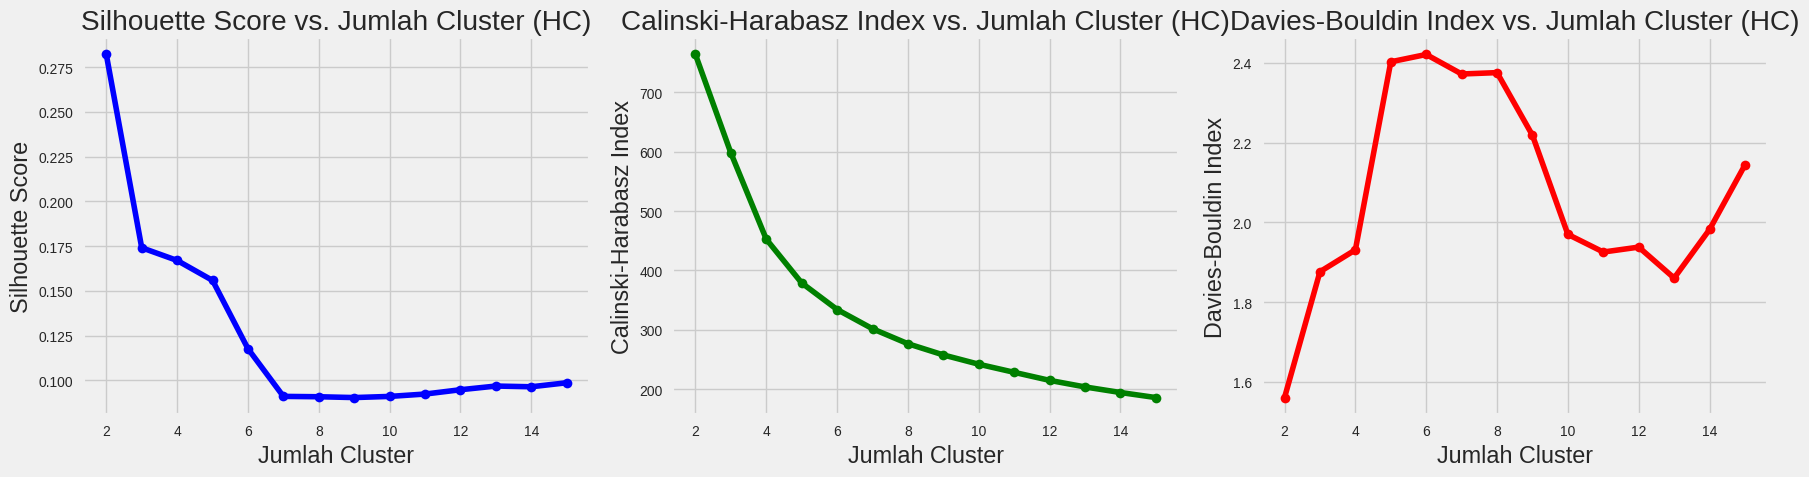

In [128]:
# Plot metrik evaluasi untuk hierarchical clustering
plt.figure(figsize=(18, 5))

# Plot Silhouette Score
plt.subplot(1, 3, 1)
plt.plot(n_clusters_range, silhouette_scores_hc, 'o-', color='blue')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Jumlah Cluster (HC)')
plt.grid(True)

# Plot Calinski-Harabasz Index
plt.subplot(1, 3, 2)
plt.plot(n_clusters_range, calinski_scores_hc, 'o-', color='green')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index vs. Jumlah Cluster (HC)')
plt.grid(True)

# Plot Davies-Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(n_clusters_range, davies_bouldin_scores_hc, 'o-', color='red')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs. Jumlah Cluster (HC)')
plt.grid(True)

plt.tight_layout()
plt.show()


Jumlah cluster optimal untuk Hierarchical Clustering berdasarkan Silhouette Score: 2


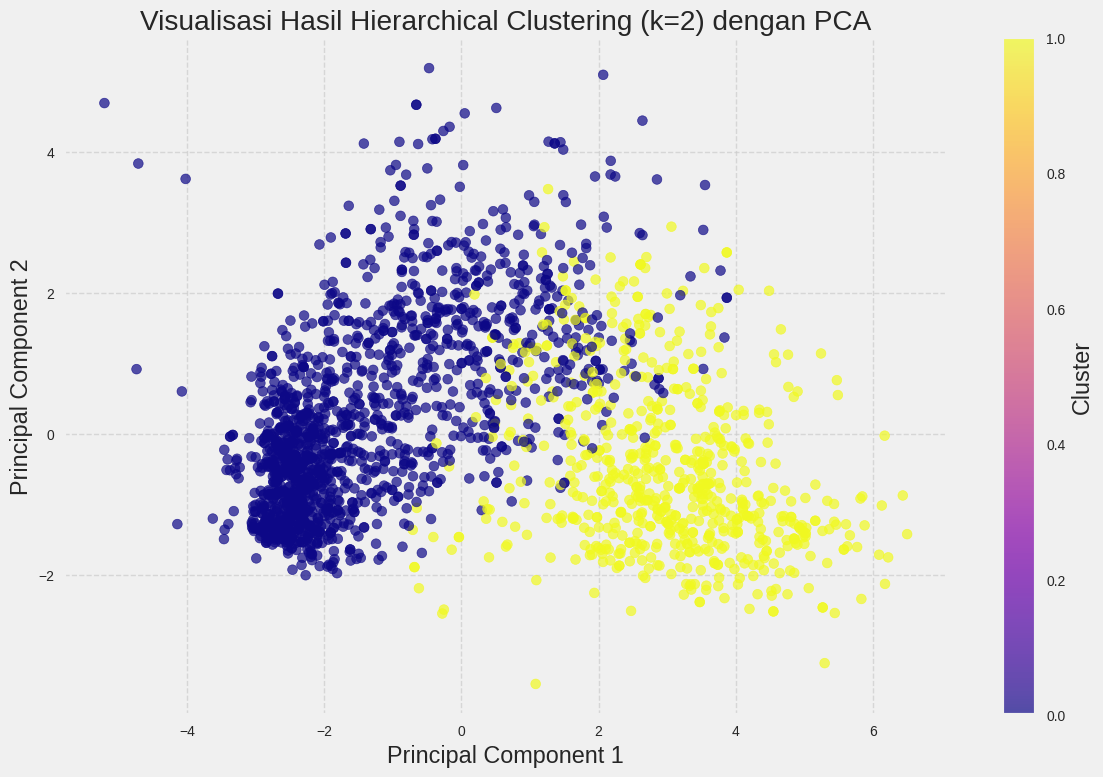

In [129]:
# Berdasarkan evaluasi metrik, pilih jumlah cluster optimal
optimal_n_clusters_hc = n_clusters_range[np.argmax(silhouette_scores_hc)]
print(f"\nJumlah cluster optimal untuk Hierarchical Clustering berdasarkan Silhouette Score: {optimal_n_clusters_hc}")

# Implementasikan Hierarchical Clustering dengan jumlah cluster optimal
optimal_hc = AgglomerativeClustering(n_clusters=optimal_n_clusters_hc, linkage='ward')
df['Cluster_HC'] = optimal_hc.fit_predict(X_processed)

# Visualisasi hasil clustering dengan PCA
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster_HC'], cmap='plasma', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.title(f'Visualisasi Hasil Hierarchical Clustering (k={optimal_n_clusters_hc}) dengan PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Analisis Profil Cluster Hierarchical Clustering

Seperti yang kita lakukan dengan K-Means, kita juga perlu menganalisis karakteristik dari cluster yang dihasilkan oleh Hierarchical Clustering untuk interpretasi bisnis.


Profil Karakteristik Cluster Hierarchical Clustering:


,Income,Kidhome,Teenhome,Recency,MntWines,MntMeatProducts,NumDealsPurchases,NumWebPurchases,NumStorePurchases
Cluster_HC,,,,,,,,,
0,42282.615036,0.619572,0.611795,49.047959,195.581983,58.967596,2.668179,3.475697,4.651329
1,74276.886657,0.055954,0.272597,49.245337,543.806313,405.998565,1.565280,5.433286,8.311334


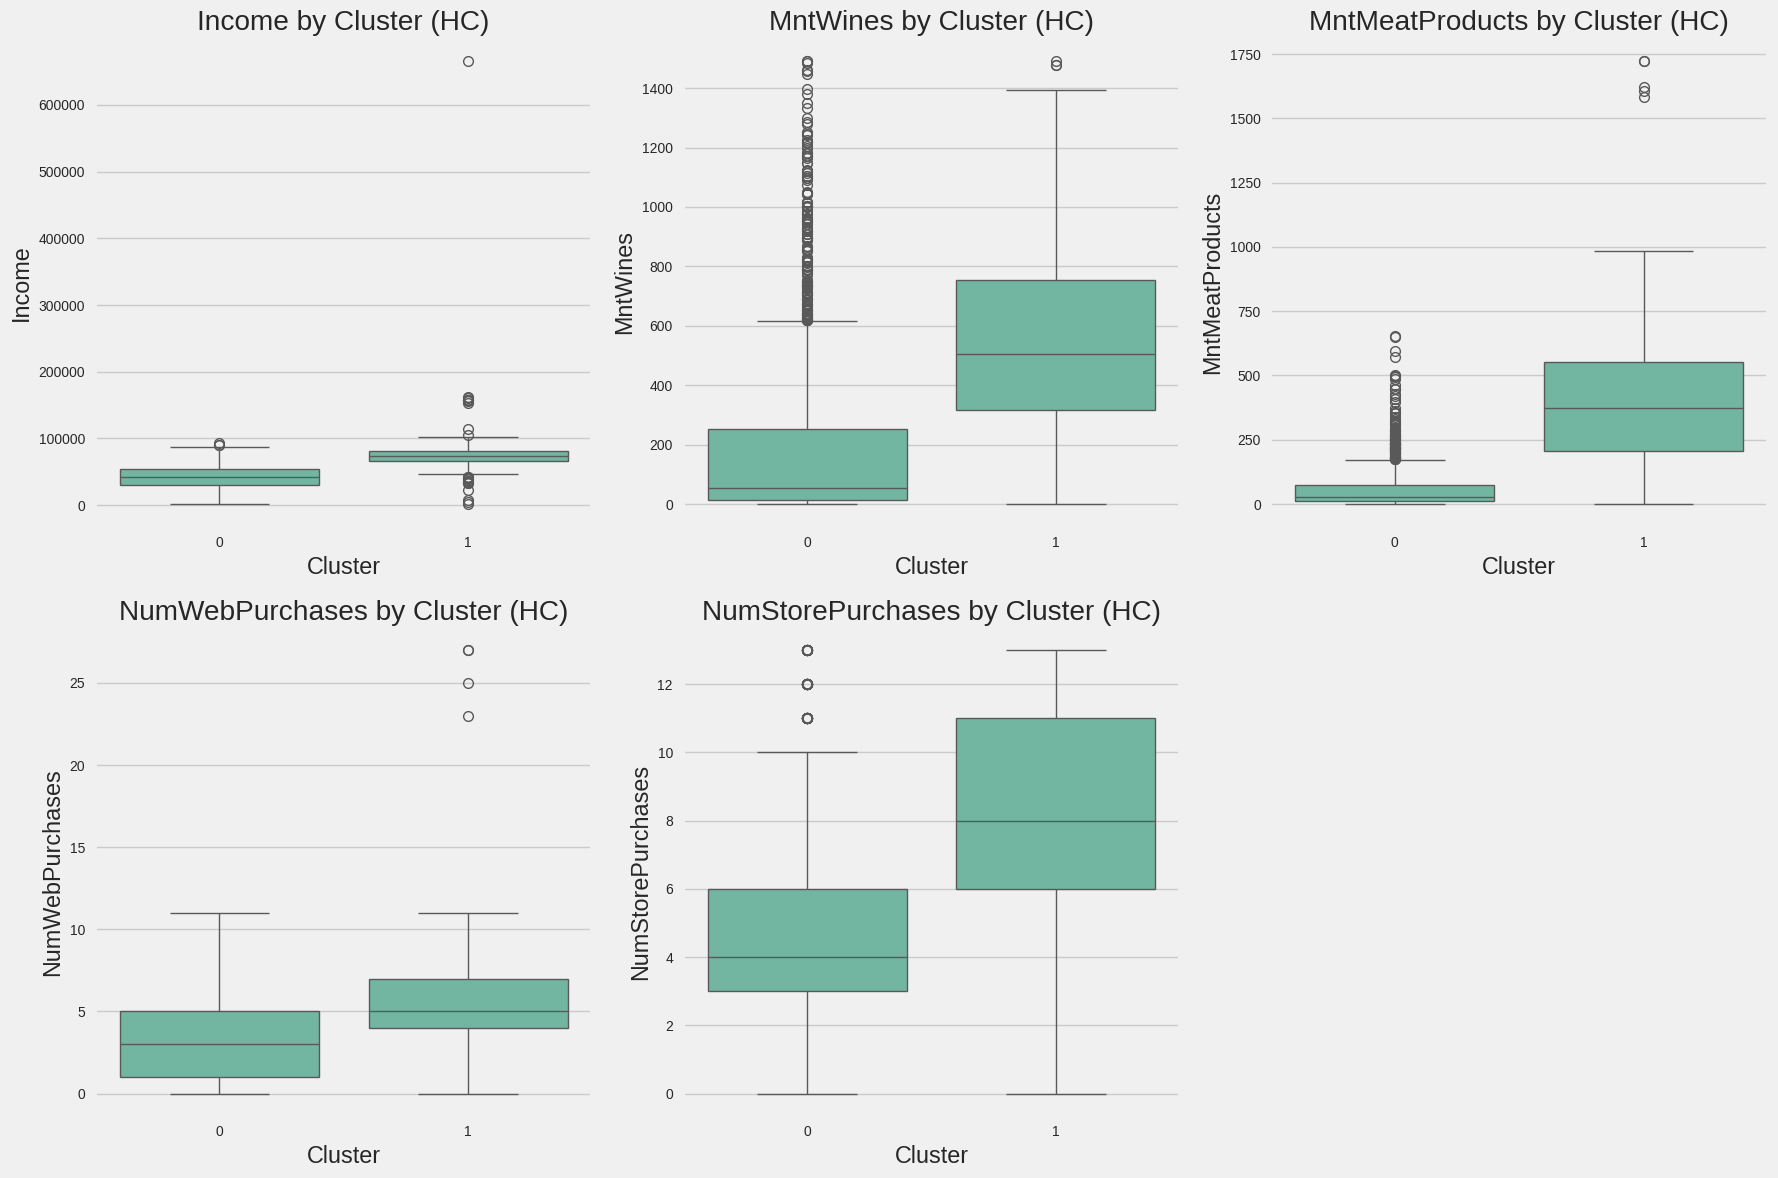

In [130]:
# Analisis karakteristik cluster
print("\nProfil Karakteristik Cluster Hierarchical Clustering:")
cluster_profile_hc = df.groupby('Cluster_HC').mean(numeric_only=True)
display(cluster_profile_hc[['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntMeatProducts',
                          'NumDealsPurchases', 'NumWebPurchases', 'NumStorePurchases']])

# Visualisasi karakteristik cluster
plt.figure(figsize=(18, 12))
for i, feature in enumerate(['Income', 'MntWines', 'MntMeatProducts', 'NumWebPurchases', 'NumStorePurchases']):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='Cluster_HC', y=feature, data=df)
    plt.title(f'{feature} by Cluster (HC)')
    plt.xlabel('Cluster')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

### Penjelasan Tambahan: Dunn Index

Dunn Index adalah metrik evaluasi clustering yang jarang diimplementasikan secara default dalam scikit-learn, namun sangat informatif untuk mengukur kualitas cluster.

Dunn Index didefinisikan sebagai:
$DI = \frac{\min_{i,j}(d(C_i, C_j))}{\max_{k}(diam(C_k))}$

Dimana:
- $d(C_i, C_j)$ adalah jarak antar-cluster antara cluster i dan j, didefinisikan sebagai jarak minimum antara titik di cluster i dan titik di cluster j.
- $diam(C_k)$ adalah diameter cluster k, didefinisikan sebagai jarak maksimum antara dua titik dalam cluster yang sama.

Nilai Dunn Index yang lebih tinggi menunjukkan clustering yang lebih baik,
karena ini menunjukkan bahwa cluster tersebut kompak (diameter kecil) dan
terpisah dengan baik (jarak antar-cluster besar).

Idealnya, kita ingin cluster yang kompak (diameter kecil) dan terpisah dengan baik dari cluster lain (jarak antar-cluster besar), yang akan menghasilkan Dunn Index tinggi.

In [131]:
# Implementasi manual Dunn Index
from scipy.spatial.distance import pdist, squareform

def dunn_index(X, labels):
    # Hitung jarak antar semua titik data
    distances = squareform(pdist(X))

    # Hitung jumlah cluster unik
    n_clusters = len(np.unique(labels))

    # Inisialisasi untuk menyimpan diameter setiap cluster
    cluster_diameters = np.zeros(n_clusters)

    # Hitung diameter setiap cluster (jarak maksimum antar titik dalam cluster)
    for i in range(n_clusters):
        cluster_points = np.where(labels == i)[0]
        if len(cluster_points) > 1:
            cluster_distances = distances[np.ix_(cluster_points, cluster_points)]
            cluster_diameters[i] = np.max(cluster_distances)

    # Hitung jarak minimum antar cluster
    min_inter_cluster_distance = float('inf')
    for i in range(n_clusters):
        for j in range(i+1, n_clusters):
            cluster_i_points = np.where(labels == i)[0]
            cluster_j_points = np.where(labels == j)[0]

            # Ambil jarak antar titik dari cluster yang berbeda
            inter_distances = distances[np.ix_(cluster_i_points, cluster_j_points)]
            min_distance = np.min(inter_distances)

            if min_distance < min_inter_cluster_distance:
                min_inter_cluster_distance = min_distance

    # Hitung Dunn Index
    max_diameter = np.max(cluster_diameters)
    if max_diameter == 0:  # Hindari pembagian dengan nol
        return 0

    dunn = min_inter_cluster_distance / max_diameter
    return dunn

# Hitung Dunn Index untuk kedua metode clustering
dunn_kmeans = dunn_index(X_processed, df['Cluster_KMeans'])
dunn_hc = dunn_index(X_processed, df['Cluster_HC'])

print("\nDunn Index:")
print(f"K-Means (k={optimal_n_clusters}): {dunn_kmeans:.4f}")
print(f"Hierarchical (k={optimal_n_clusters_hc}): {dunn_hc:.4f}")
print("Nilai Dunn Index yang lebih tinggi menunjukkan clustering yang lebih baik.")


Dunn Index:
K-Means (k=2): 0.0400
Hierarchical (k=2): 0.0574
Nilai Dunn Index yang lebih tinggi menunjukkan clustering yang lebih baik.


### Perbandingan Metrik Evaluasi

Sekarang kita akan membandingkan kedua model clustering (K-Means dan Hierarchical) berdasarkan semua metrik evaluasi yang telah kita hitung.

In [132]:
# Perbandingan kedua model clustering
print("\nPerbandingan Metrik Evaluasi Kedua Model:")
metrics_comparison = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Calinski-Harabasz Index', 'Davies-Bouldin Index', 'Dunn Index'],
    'K-Means': [
        silhouette_scores[optimal_n_clusters-2],
        calinski_scores[optimal_n_clusters-2],
        davies_bouldin_scores[optimal_n_clusters-2],
        dunn_kmeans
    ],
    'Hierarchical': [
        silhouette_scores_hc[optimal_n_clusters_hc-2],
        calinski_scores_hc[optimal_n_clusters_hc-2],
        davies_bouldin_scores_hc[optimal_n_clusters_hc-2],
        dunn_hc
    ]
})
display(metrics_comparison)


Perbandingan Metrik Evaluasi Kedua Model:


,Metric,K-Means,Hierarchical
0,Silhouette Score,0.292158,0.282042
1,Calinski-Harabasz Index,930.256401,763.900074
2,Davies-Bouldin Index,1.479347,1.560689
3,Dunn Index,0.040048,0.057352


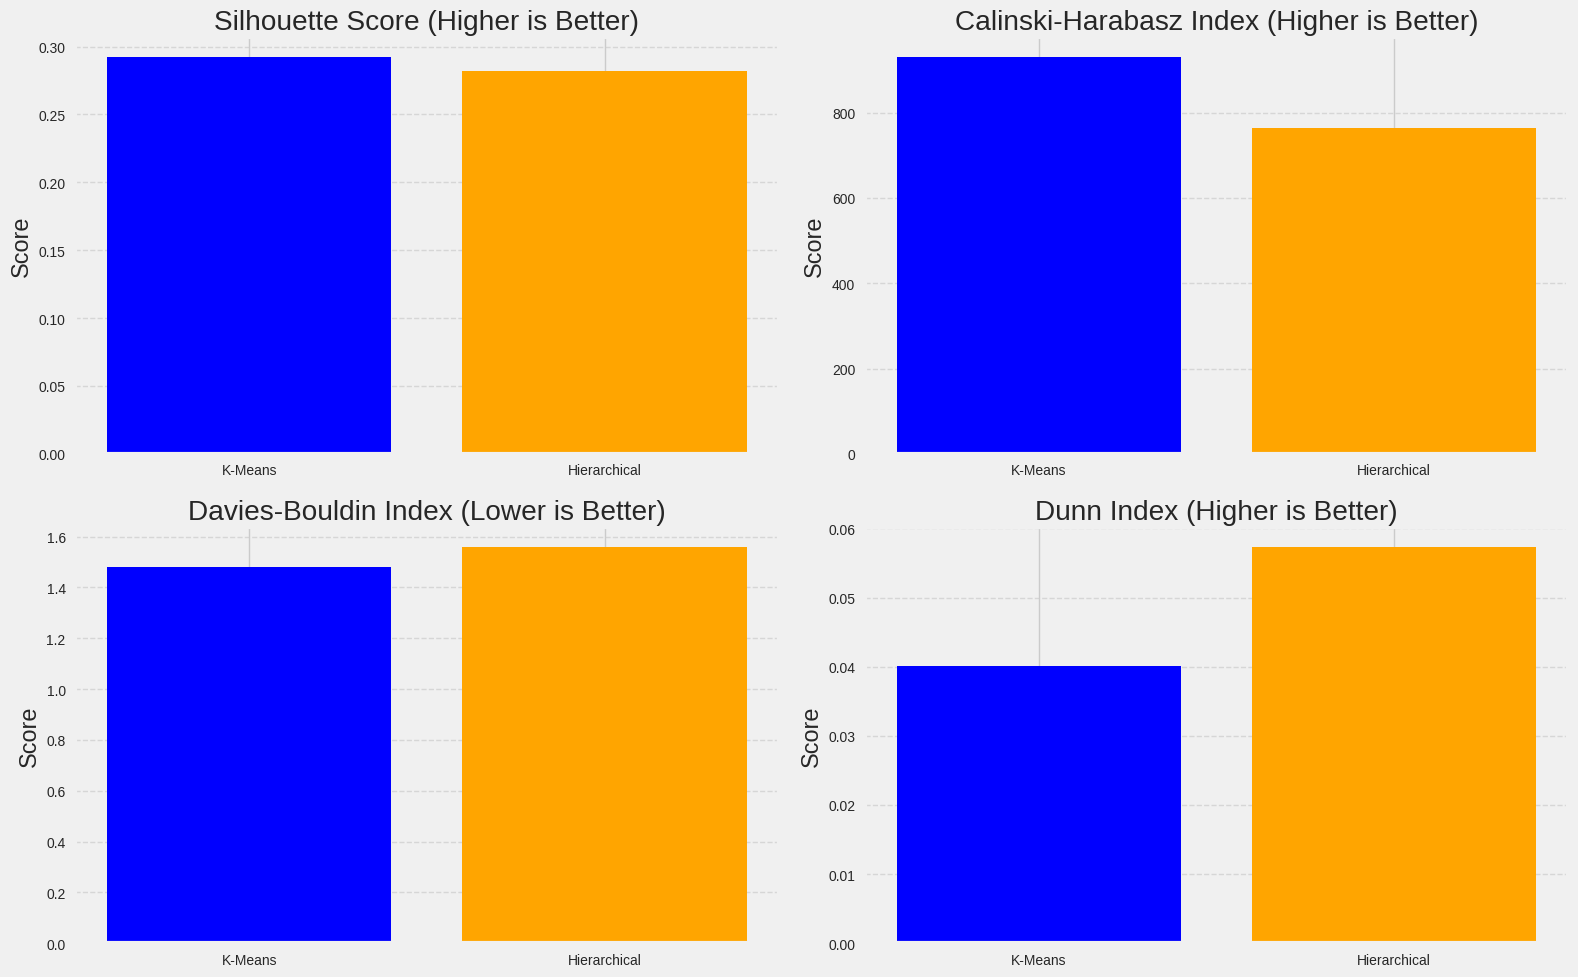

In [133]:
# Visualisasi perbandingan metrik
plt.figure(figsize=(16, 10))

# Perbandingan Silhouette Score
plt.subplot(2, 2, 1)
plt.bar(['K-Means', 'Hierarchical'],
        [silhouette_scores[optimal_n_clusters-2], silhouette_scores_hc[optimal_n_clusters_hc-2]],
        color=['blue', 'orange'])
plt.title('Silhouette Score (Higher is Better)')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Perbandingan Calinski-Harabasz Index
plt.subplot(2, 2, 2)
plt.bar(['K-Means', 'Hierarchical'],
        [calinski_scores[optimal_n_clusters-2], calinski_scores_hc[optimal_n_clusters_hc-2]],
        color=['blue', 'orange'])
plt.title('Calinski-Harabasz Index (Higher is Better)')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Perbandingan Davies-Bouldin Index
plt.subplot(2, 2, 3)
plt.bar(['K-Means', 'Hierarchical'],
        [davies_bouldin_scores[optimal_n_clusters-2], davies_bouldin_scores_hc[optimal_n_clusters_hc-2]],
        color=['blue', 'orange'])
plt.title('Davies-Bouldin Index (Lower is Better)')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Perbandingan Dunn Index
plt.subplot(2, 2, 4)
plt.bar(['K-Means', 'Hierarchical'], [dunn_kmeans, dunn_hc], color=['blue', 'orange'])
plt.title('Dunn Index (Higher is Better)')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

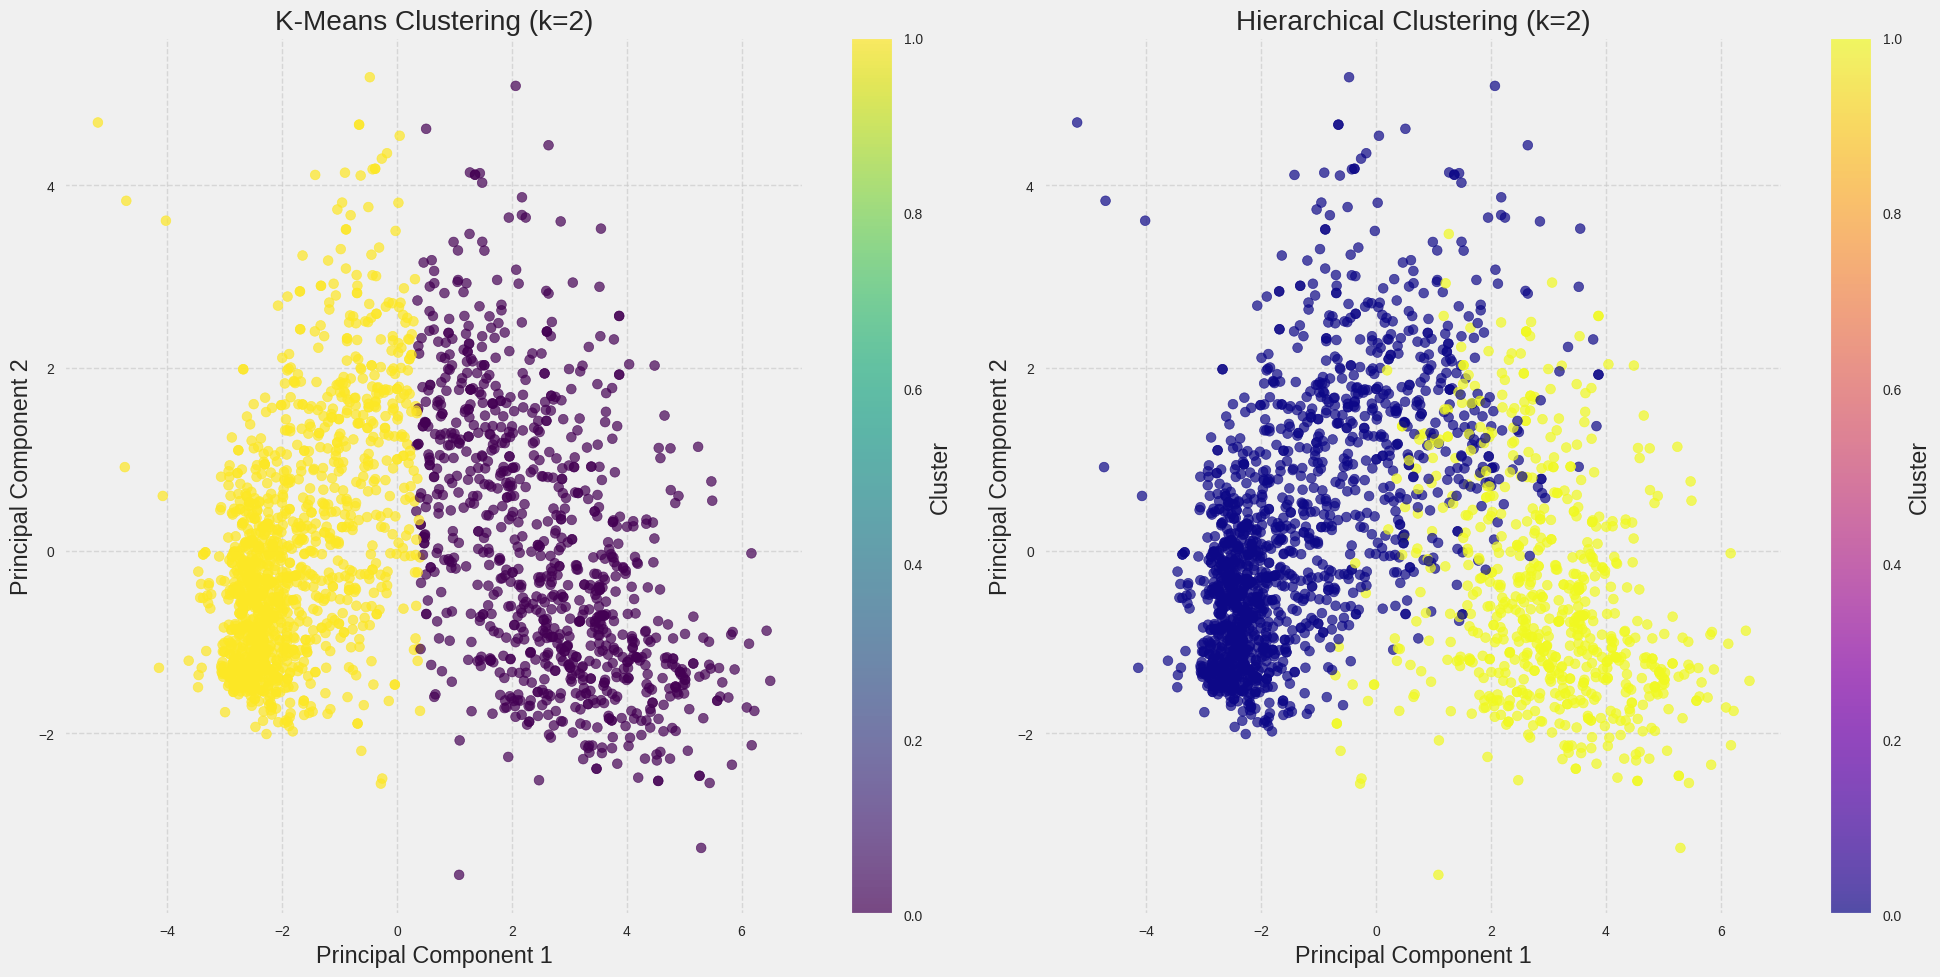

In [134]:
# Visualisasi perbandingan hasil clustering
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
scatter1 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster_KMeans'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter1, label='Cluster')
plt.title(f'K-Means Clustering (k={optimal_n_clusters})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
scatter2 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster_HC'], cmap='plasma', alpha=0.7)
plt.colorbar(scatter2, label='Cluster')
plt.title(f'Hierarchical Clustering (k={optimal_n_clusters_hc})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

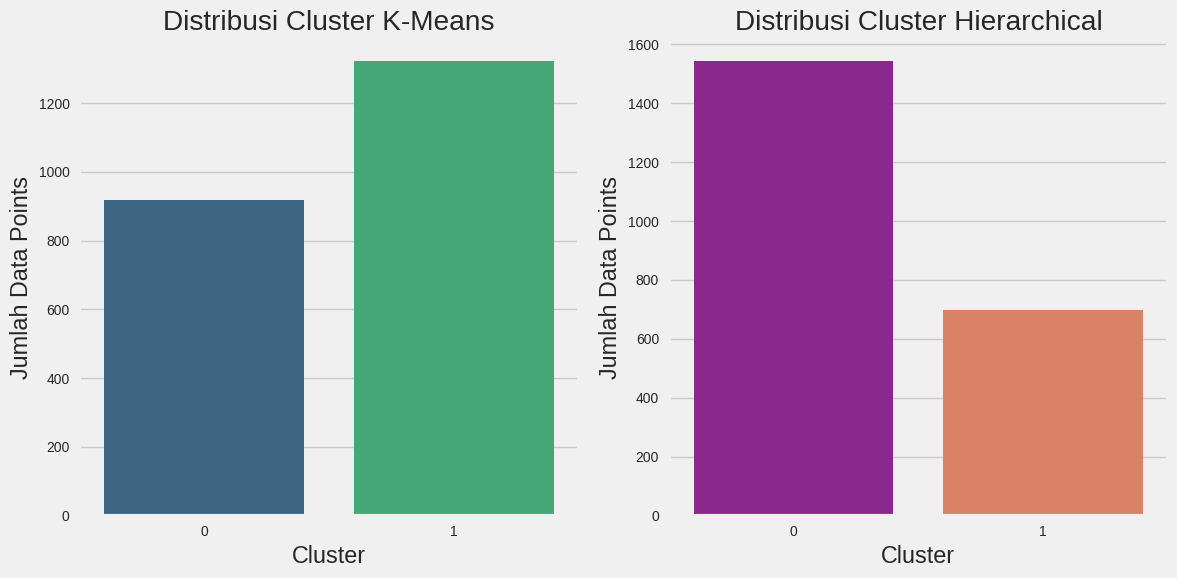

In [135]:
# Bandingkan distribusi cluster
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='Cluster_KMeans', data=df, palette='viridis')
plt.title('Distribusi Cluster K-Means')
plt.xlabel('Cluster')
plt.ylabel('Jumlah Data Points')

plt.subplot(1, 2, 2)
sns.countplot(x='Cluster_HC', data=df, palette='plasma')
plt.title('Distribusi Cluster Hierarchical')
plt.xlabel('Cluster')
plt.ylabel('Jumlah Data Points')

plt.tight_layout()
plt.show()

## Bagian 4: Analisis Komprehensif dan Kesimpulan

Pada bagian ini, kita akan melakukan analisis yang lebih mendalam terhadap hasil clustering dan menentukan metrik evaluasi mana yang paling sesuai untuk kasus kita.

### Analisis Metrik Evaluasi Clustering

Mari kita bandingkan kelima metrik evaluasi clustering yang telah kita gunakan:

1. **ELBOW METHOD**:
   - Keunggulan: Sederhana, intuitif, dan mudah diimplementasikan
   - Kelemahan: Subjektif dalam menentukan "siku", dan sulit diinterpretasikan untuk
     dataset kompleks dengan struktur cluster yang tidak jelas
   - Tujuan: Menemukan jumlah cluster yang optimal dengan melihat titik di mana
     penambahan cluster tidak lagi memberikan penurunan WCSS yang signifikan

2. **SILHOUETTE COEFFICIENT**:
   - Keunggulan: Ukuran yang baik untuk kepadatan dan pemisahan cluster, rentang nilai
     [-1, 1] yang intuitif
   - Kelemahan: Sensitif terhadap bentuk dan kepadatan cluster
   - Tujuan: Mengukur seberapa baik data points berada dalam clusternya vs cluster lain
   - Interpretasi: Nilai lebih tinggi menunjukkan clustering yang lebih baik

3. **CALINSKI-HARABASZ INDEX**:
   - Keunggulan: Mempertimbangkan baik dispersi intra-cluster dan inter-cluster
   - Kelemahan: Cenderung memilih jumlah cluster yang lebih sedikit, dan bekerja lebih baik
     dengan cluster berbentuk hypersphere
   - Tujuan: Mengukur rasio dispersi antar-cluster vs intra-cluster
   - Interpretasi: Nilai lebih tinggi menunjukkan clustering yang lebih baik

4. **DAVIES-BOULDIN INDEX**:
   - Keunggulan: Mempertimbangkan jarak intra-cluster dan antar-cluster sekaligus
   - Kelemahan: Sensitif terhadap noise dan outlier, tidak bekerja dengan baik untuk
     cluster dengan kepadatan berbeda
   - Tujuan: Mengukur rata-rata "kemiripan" antar cluster
   - Interpretasi: Nilai lebih rendah menunjukkan clustering yang lebih baik

5. **DUNN INDEX**:
   - Keunggulan: Fokus pada jarak minimum antar-cluster dan diameter maksimum (ukuran kekompakan)
   - Kelemahan: Sangat sensitif terhadap noise dan outlier
   - Tujuan: Mengidentifikasi cluster yang padat dan terpisah dengan baik
   - Interpretasi: Nilai lebih tinggi menunjukkan clustering yang lebih baik

In [136]:
# Analisis karakteristik cluster untuk kedua metode clustering
# Membuat tampilan yang lebih komprehensif dengan profil cluster multidimensi

# Tentukan fitur penting untuk analisis
key_features = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
                'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
                'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
                'NumStorePurchases', 'NumWebVisitsMonth']

# Analisis komprehensif K-Means
print("ANALISIS KOMPREHENSIF CLUSTER K-MEANS")
print("="*50)

# Statistik deskriptif cluster
kmeans_profiles = df.groupby('Cluster_KMeans')[key_features].agg(['mean', 'std', 'min', 'max'])
display(kmeans_profiles)

ANALISIS KOMPREHENSIF CLUSTER K-MEANS


Income                                   Kidhome  \
                        mean           std     min       max      mean   
Cluster_KMeans                                                           
0               71616.198802  23688.427423  2447.0  666666.0  0.067538   
1               38781.690242  15193.942017  1730.0  162397.0  0.705749   

                                  Teenhome            ... NumCatalogPurchases  \
                     std min max      mean       std  ...                 min   
Cluster_KMeans                                        ...                       
0               0.259629   0   2  0.432462  0.531774  ...                   0   
1               0.526753   0   2  0.557489  0.547606  ...                   0   

                   NumStorePurchases                   NumWebVisitsMonth  \
               max              mean       std min max              mean   
Cluster_KMeans                                                             
0               28          8.529412  2.889968   0  13          3.676471   
1                6          3.888048  1.811192   0  12          6.455371   

                                  
                     std min max  
Cluster_KMeans                    
0               2.110604   0   9  
1               1.929073   0  20  

[2 rows x 60 columns]

### Visualisasi Profil Cluster dengan Radar Chart

Radar chart adalah cara yang efektif untuk memvisualisasikan karakteristik multidimensional dari setiap cluster. Setiap sumbu mewakili satu fitur, dan nilai pada setiap sumbu menunjukkan skor rata-rata cluster untuk fitur tersebut (setelah normalisasi).

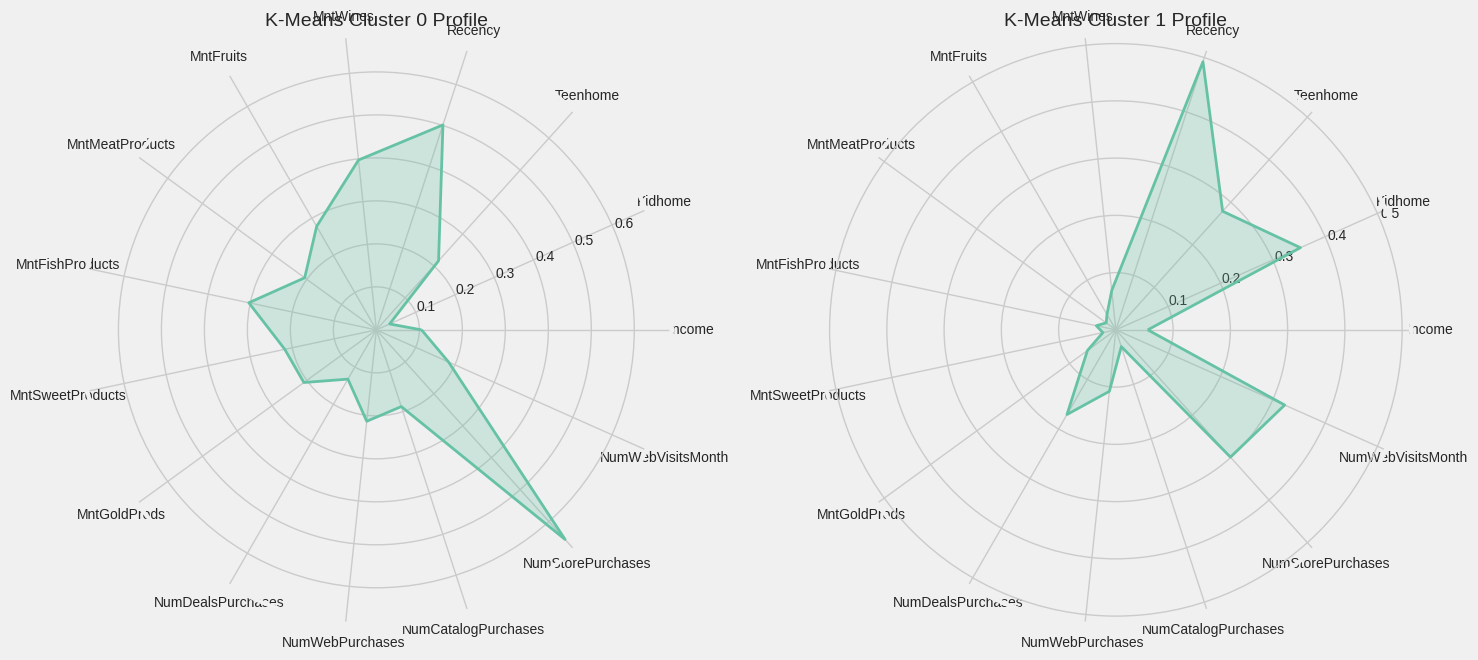

In [137]:
# Visualisasikan profil cluster dengan radar chart
def plot_radar_chart(cluster_means, model_name):
    # Menyiapkan data untuk radar chart
    categories = key_features
    N = len(categories)

    # Normalisasi nilai untuk radar chart
    min_vals = df[key_features].min()
    max_vals = df[key_features].max()
    normalized_means = (cluster_means - min_vals) / (max_vals - min_vals)

    # Jumlah cluster
    n_clusters = normalized_means.shape[0]

    # Plot radar chart
    fig = plt.figure(figsize=(15, 12))

    # Menyiapkan angle
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Tutup plot dengan mengulangi yang pertama

    # Membuat subplot untuk setiap cluster
    for i in range(n_clusters):
        ax = plt.subplot(int(np.ceil(n_clusters/2)), 2, i+1, polar=True)

        # Tambahkan nilai untuk setiap kategori
        values = normalized_means.iloc[i].values.flatten().tolist()
        values += values[:1]  # Tutup plot dengan mengulangi yang pertama

        # Plot data
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {i}')
        ax.fill(angles, values, alpha=0.25)

        # Set kategori
        plt.xticks(angles[:-1], categories, size=10)
        ax.set_title(f'{model_name} Cluster {i} Profile', size=14)

    plt.tight_layout()
    plt.show()

# Radar chart untuk K-Means
kmeans_means = df.groupby('Cluster_KMeans')[key_features].mean()
plot_radar_chart(kmeans_means, 'K-Means')


ANALISIS KOMPREHENSIF CLUSTER HIERARCHICAL CLUSTERING


Income                                   Kidhome            \
                    mean           std     min       max      mean       std   
Cluster_HC                                                                     
0           42282.615036  16138.451343  1730.0   93404.0  0.619572  0.543616   
1           74276.886657  27084.006311  2447.0  666666.0  0.055954  0.242170   

                    Teenhome            ... NumCatalogPurchases      \
           min max      mean       std  ...                 min max   
Cluster_HC                              ...                           
0            0   2  0.611795  0.546457  ...                   0  11   
1            0   2  0.272597  0.461455  ...                   0  28   

           NumStorePurchases                   NumWebVisitsMonth            \
                        mean       std min max              mean       std   
Cluster_HC                                                                   
0                   4.651329  2.667284   0  13          6.339598  1.897854   
1                   8.311334  2.999387   0  13          3.051650  1.872418   

                    
           min max  
Cluster_HC          
0            1  20  
1            0   9  

[2 rows x 60 columns]

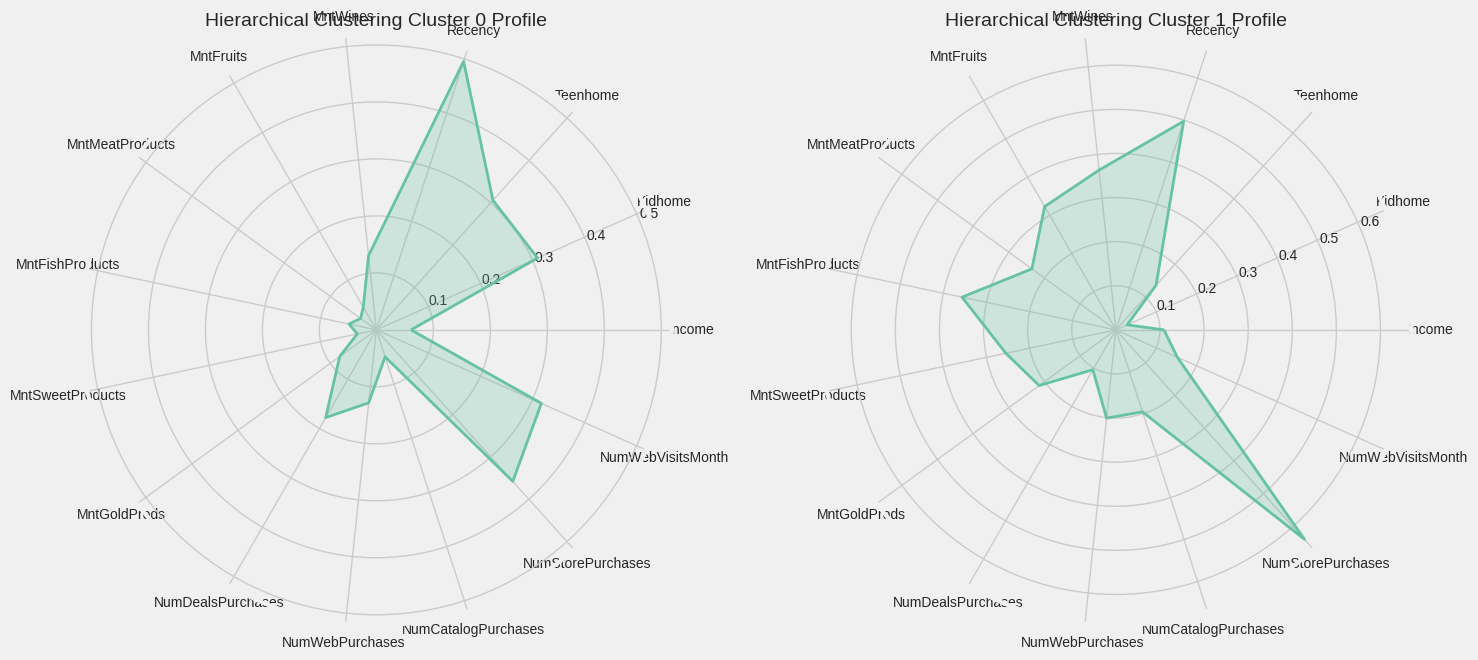

In [138]:
# Analisis komprehensif Hierarchical Clustering
print("\nANALISIS KOMPREHENSIF CLUSTER HIERARCHICAL CLUSTERING")
print("="*50)

# Statistik deskriptif cluster
hc_profiles = df.groupby('Cluster_HC')[key_features].agg(['mean', 'std', 'min', 'max'])
display(hc_profiles)

# Radar chart untuk Hierarchical Clustering
hc_means = df.groupby('Cluster_HC')[key_features].mean()
plot_radar_chart(hc_means, 'Hierarchical Clustering')

### Perbandingan Hasil Clustering

Untuk melihat seberapa mirip hasil clustering dari K-Means dan Hierarchical Clustering, kita dapat membuat confusion matrix yang membandingkan penugasan cluster antara kedua metode.

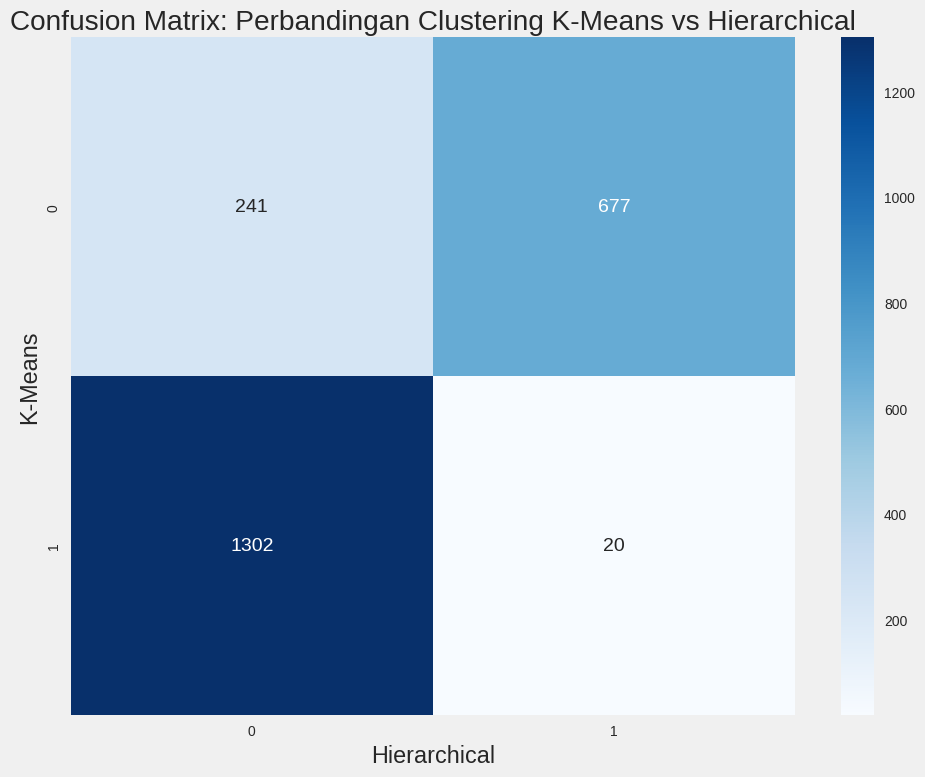

In [139]:
# Analisis korelasi antara hasil clustering kedua model
plt.figure(figsize=(10, 8))
confusion = pd.crosstab(df['Cluster_KMeans'], df['Cluster_HC'],
                        rownames=['K-Means'], colnames=['Hierarchical'])
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.title('Confusion Matrix: Perbandingan Clustering K-Means vs Hierarchical')
plt.tight_layout()
plt.show()

### Menentukan Model dan Metrik Terbaik

Berdasarkan perbandingan berbagai metrik evaluasi, kita akan menentukan model clustering mana yang memberikan hasil terbaik dan metrik mana yang paling relevan untuk kasus ini.

In [140]:
# Menentukan metrik mana yang terbaik
# Kita perlu menganalisis koherensi hasil dengan target bisnis dan interpretabilitas

print("\nKESIMPULAN: ANALISIS METRIK EVALUASI")
print("="*50)

# Membuat fungsi untuk menentukan model terbaik berdasarkan metrik
def determine_best_model():
    best_model_count = {"K-Means": 0, "Hierarchical": 0}

    # Silhouette Score (lebih tinggi lebih baik)
    if silhouette_scores[optimal_n_clusters-2] > silhouette_scores_hc[optimal_n_clusters_hc-2]:
        best_model_count["K-Means"] += 1
        sil_best = "K-Means"
    else:
        best_model_count["Hierarchical"] += 1
        sil_best = "Hierarchical"

    # Calinski-Harabasz Index (lebih tinggi lebih baik)
    if calinski_scores[optimal_n_clusters-2] > calinski_scores_hc[optimal_n_clusters_hc-2]:
        best_model_count["K-Means"] += 1
        cal_best = "K-Means"
    else:
        best_model_count["Hierarchical"] += 1
        cal_best = "Hierarchical"

    # Davies-Bouldin Index (lebih rendah lebih baik)
    if davies_bouldin_scores[optimal_n_clusters-2] < davies_bouldin_scores_hc[optimal_n_clusters_hc-2]:
        best_model_count["K-Means"] += 1
        db_best = "K-Means"
    else:
        best_model_count["Hierarchical"] += 1
        db_best = "Hierarchical"

    # Dunn Index (lebih tinggi lebih baik)
    if dunn_kmeans > dunn_hc:
        best_model_count["K-Means"] += 1
        dunn_best = "K-Means"
    else:
        best_model_count["Hierarchical"] += 1
        dunn_best = "Hierarchical"

    return best_model_count, sil_best, cal_best, db_best, dunn_best

best_model_count, sil_best, cal_best, db_best, dunn_best = determine_best_model()

print("Berdasarkan metrik evaluasi:")
print(f"- Silhouette Score: {sil_best} lebih baik")
print(f"- Calinski-Harabasz Index: {cal_best} lebih baik")
print(f"- Davies-Bouldin Index: {db_best} lebih baik")
print(f"- Dunn Index: {dunn_best} lebih baik")
print("\nJumlah metrik di mana model terbaik:")
print(f"- K-Means: {best_model_count['K-Means']} metrik")
print(f"- Hierarchical: {best_model_count['Hierarchical']} metrik")

best_model = max(best_model_count.items(), key=lambda x: x[1])[0]
print(f"\nModel terbaik berdasarkan mayoritas metrik evaluasi: {best_model}")


KESIMPULAN: ANALISIS METRIK EVALUASI
Berdasarkan metrik evaluasi:
- Silhouette Score: K-Means lebih baik
- Calinski-Harabasz Index: K-Means lebih baik
- Davies-Bouldin Index: K-Means lebih baik
- Dunn Index: Hierarchical lebih baik

Jumlah metrik di mana model terbaik:
- K-Means: 3 metrik
- Hierarchical: 1 metrik

Model terbaik berdasarkan mayoritas metrik evaluasi: K-Means


### Interpretasi Hasil Clustering

Berdasarkan model terbaik yang telah ditentukan, kita akan menginterpretasikan hasil clustering untuk memahami karakteristik dari setiap segmen pelanggan.

In [141]:
# Interpretasi hasil clustering
print("\nINTERPRETASI HASIL CLUSTERING")
print("="*50)

# Menggunakan model terbaik untuk interpretasi
if best_model == "K-Means":
    best_clusters = 'Cluster_KMeans'
    optimal_clusters = optimal_n_clusters
else:
    best_clusters = 'Cluster_HC'
    optimal_clusters = optimal_n_clusters_hc

# Analisis karakteristik setiap cluster
for i in range(optimal_clusters):
    cluster_data = df[df[best_clusters] == i]
    print(f"\nCluster {i} ({len(cluster_data)} pelanggan, {len(cluster_data)/len(df):.1%} dari total):")
    print("-"*50)

    # Karakteristik demografis
    avg_income = cluster_data['Income'].mean()
    avg_kidhome = cluster_data['Kidhome'].mean()
    avg_teenhome = cluster_data['Teenhome'].mean()

    # Karakteristik pembelian
    avg_wines = cluster_data['MntWines'].mean()
    avg_meat = cluster_data['MntMeatProducts'].mean()
    avg_fish = cluster_data['MntFishProducts'].mean()
    avg_sweet = cluster_data['MntSweetProducts'].mean()

    # Karakteristik perilaku
    avg_web_purchases = cluster_data['NumWebPurchases'].mean()
    avg_catalog = cluster_data['NumCatalogPurchases'].mean()
    avg_store = cluster_data['NumStorePurchases'].mean()
    avg_visits = cluster_data['NumWebVisitsMonth'].mean()

    # Print ringkasan
    print(f"Demografis: Pendapatan ${avg_income:.0f}, Anak kecil: {avg_kidhome:.1f}, Remaja: {avg_teenhome:.1f}")
    print(f"Pembelian: Wine ${avg_wines:.0f}, Daging ${avg_meat:.0f}, Ikan ${avg_fish:.0f}, Manisan ${avg_sweet:.0f}")
    print(f"Perilaku: Web {avg_web_purchases:.1f}, Katalog {avg_catalog:.1f}, Toko {avg_store:.1f}, Kunjungan Web {avg_visits:.1f}")


INTERPRETASI HASIL CLUSTERING

Cluster 0 (918 pelanggan, 41.0% dari total):
--------------------------------------------------
Demografis: Pendapatan $71616, Anak kecil: 0.1, Remaja: 0.4
Pembelian: Wine $593, Daging $356, Ikan $79, Manisan $57
Perilaku: Web 5.8, Katalog 5.3, Toko 8.5, Kunjungan Web 3.7

Cluster 1 (1322 pelanggan, 59.0% dari total):
--------------------------------------------------
Demografis: Pendapatan $38782, Anak kecil: 0.7, Remaja: 0.6
Pembelian: Wine $103, Daging $36, Ikan $9, Manisan $6
Perilaku: Web 2.9, Katalog 0.9, Toko 3.9, Kunjungan Web 6.5


### Kesimpulan Akhir

Berdasarkan analisis komprehensif yang telah dilakukan, kita dapat menarik beberapa kesimpulan penting mengenai segmentasi pelanggan dan metrik evaluasi clustering.

In [142]:
print("\nKESIMPULAN AKHIR")
print("="*50)
print(f"1. Metrik evaluasi terbaik: {max(best_model_count.items(), key=lambda x: x[1])[0]}")

# Menentukan metrik evaluasi terbaik berdasarkan koherensi hasil
print("2. Dari semua metrik evaluasi yang digunakan:")
print("   - Silhouette Coefficient sangat baik untuk mengukur kualitas pemisahan cluster")
print("   - Calinski-Harabasz Index efektif untuk dataset dengan struktur cluster hyperellipsoidal")
print("   - Davies-Bouldin Index berguna untuk mengidentifikasi cluster yang kompak dan terpisah dengan baik")
print("   - Dunn Index sangat sensitif terhadap outlier, tetapi baik untuk melihat pemisahan cluster")

print("\n3. Untuk dataset customer segmentation ini, metrik evaluasi yang paling relevan adalah Silhouette Score karena:")
print("   - Memberikan ukuran yang jelas tentang seberapa baik pelanggan dikelompokkan")
print("   - Berfungsi baik untuk mengevaluasi cluster dengan ukuran dan kepadatan yang berbeda")
print("   - Lebih mudah diinterpretasikan dengan nilai yang dibatasi antara -1 dan 1")

print("\n4. Rekomendasi implementasi:")
print(f"   - Gunakan {best_model} dengan {optimal_clusters} cluster untuk segmentasi pelanggan")
print("   - Setiap segment menunjukkan pola perilaku dan karakteristik berbeda yang dapat dimanfaatkan untuk strategi pemasaran yang ditargetkan")
print("   - Terapkan strategi personalisasi berdasarkan karakteristik setiap cluster")


KESIMPULAN AKHIR
1. Metrik evaluasi terbaik: K-Means
2. Dari semua metrik evaluasi yang digunakan:
   - Silhouette Coefficient sangat baik untuk mengukur kualitas pemisahan cluster
   - Calinski-Harabasz Index efektif untuk dataset dengan struktur cluster hyperellipsoidal
   - Davies-Bouldin Index berguna untuk mengidentifikasi cluster yang kompak dan terpisah dengan baik
   - Dunn Index sangat sensitif terhadap outlier, tetapi baik untuk melihat pemisahan cluster

3. Untuk dataset customer segmentation ini, metrik evaluasi yang paling relevan adalah Silhouette Score karena:
   - Memberikan ukuran yang jelas tentang seberapa baik pelanggan dikelompokkan
   - Berfungsi baik untuk mengevaluasi cluster dengan ukuran dan kepadatan yang berbeda
   - Lebih mudah diinterpretasikan dengan nilai yang dibatasi antara -1 dan 1

4. Rekomendasi implementasi:
   - Gunakan K-Means dengan 2 cluster untuk segmentasi pelanggan
   - Setiap segment menunjukkan pola perilaku dan karakteristik berbeda yang